




# Mortgage task

Let's have a look at how ml can help us to improve metrics of mortgage and make the right decision about it

## Mortgage task

The company deals with mortgage. It has 25 billion rubles which it can lend within one year. The goal of the company is to get a maximum profit from its investment.

Details:
1. The company issues mortgage according to `__priority` column. In the first place the company issues mortgage to the clients with maximum value of `__priority` until the account has no money.

> Example: Our account has 50 rubles and we have only three mortgage requests [20, 30, 50] rubles with priority [0.5, 1, 0.3] respectively. The first mortgage will be issued for 30 rubles (the highest priority which is equal to 1). Our account has 20 rubles after this deal (50 - 30). The second mortgage will be issued for 20 rubles (priority = 0.5). The mortgage issue process will stop, because our account has 0 rubles after the deal.

2. The mortgage is considered issued if the company has money on the account and the predicted value is in the range within +/- 10% of real price.

> Example:
> The price of the real estate is 10 million rubles. The mortgage will be issued if predicted price is in the range within +/- 10%
> - from 9 to 10 millions rubles, mortgage will be issued for **predicted** price
> - from 10 to 11 millions rubles, mortgage will be issued for **real** price (10 million)

3. Some clients may go into debt. In this case the profit will be negative (see function `call_all_metrics` for more details)

> Example:
> 	We have only 3 mortgage loans worth [10, 30, 50] rubles and some clients get into debt [no, yes, no] respectively. In this case, we only get profit from clients 1,3 from client 2 we have loss (see detail coefficients in function `call_all_metrics`)

4. The profit is formed as percentage of the cost of the mortgage. (for exact coefficients see the function `calc_all_metrics`)

# Minimal Viable Product

Your team has already collected a training dataset (`train`) with the most important features for the client and for the purchased apartment (59 features in total) and 2 target variables.
Trained 2 ML models and wrote an algorithm that generates a new column (`__priority`) in the dataset in which there will be a priority for issuing loans.

Target variables:
1. `__price_doc` - real cost of building, million rubles
2. `__churn` - the fact that the client has gone into debt, 1 - debt, 0 - no

Columns with predictions:
1. `__price_predict` - predicted value of real estate, in million rubles (from 0 to infinity)
2. `__churn_prob` - predicted probability that the client will go into debt, probability (from 0 to 1 inclusive)
3. `__priority` - priority in issuing a loan (first of all, the loan is issued to clients with the highest value), (from minus infinity to + infinity)
> If the priority value is below 0, then the mortgage will not be issued under any circumstances

In [23]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings

!pip install category_encoders
from category_encoders import TargetEncoder


In [24]:

pd.options.display.max_rows = 1000


NAME = "Belton_Manhica"

#read data files
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/0_Belton_Manhica_test.csv')

TRAIN_SHAPE, TEST_SHAPE = train.shape, test.shape
TRAIN_SHAPE, TEST_SHAPE

((20483, 61), (9183, 60))

The train data has more columns than the test one.

1. EXPLORATORY DATA ANALYSIS

In [ ]:
#show data type, and count of non-null values for all columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20483 entries, 0 to 20482
Data columns (total 61 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   max_floor                              10911 non-null  float64
 1   state                                  8469 non-null   float64
 2   marital_status                         20483 non-null  object 
 3   big_market_raion                       20483 non-null  object 
 4   total_revolving_bal                    20483 non-null  int64  
 5   market_count_1500                      20483 non-null  int64  
 6   leisure_count_3000                     20483 non-null  int64  
 7   total_ct_chng_q4_q1                    20483 non-null  float64
 8   water_1line                            20483 non-null  object 
 9   railroad_station_walk_km               20473 non-null  float64
 10  culture_objects_top_25                 20483 non-null  object 
 11  co

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9183 entries, 0 to 9182
Data columns (total 60 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             9183 non-null   int64  
 1   max_floor                              9183 non-null   float64
 2   state                                  7768 non-null   float64
 3   marital_status                         9183 non-null   object 
 4   big_market_raion                       9183 non-null   object 
 5   total_revolving_bal                    9183 non-null   int64  
 6   market_count_1500                      9183 non-null   int64  
 7   leisure_count_3000                     9183 non-null   int64  
 8   total_ct_chng_q4_q1                    9183 non-null   float64
 9   water_1line                            9183 non-null   object 
 10  railroad_station_walk_km               9170 non-null   float64
 11  cult

*The test data is missing the following columns for __churn and __price_doc, and has one column that is not in the train data (Unnamed: 0)*

In [ ]:
train


max_floor  state marital_status big_market_raion  total_revolving_bal  \
0            NaN    NaN         Single               no                 1906   
1            NaN    NaN        Married               no                   12   
2            NaN    NaN        Married               no                 2153   
3            NaN    NaN        Married               no                 1806   
4            NaN    NaN        Married               no                  753   
...          ...    ...            ...              ...                  ...   
20478       16.0    3.0        Married               no                 1377   
20479       17.0    1.0        Married               no                 1636   
20480       12.0    3.0        Married               no                 1490   
20481       17.0    3.0         Single               no                 1220   
20482       17.0    3.0         Single              yes                  719   

       market_count_1500  leisure_count_3000  total_ct_chng_q4_q1 water_1line  \
0                      1                   0                0.694          no   
1                      0                   6                0.693          no   
2                      5                   0                0.831          no   
3                      2                   0                0.638          no   
4                      2                  40                0.902          no   
...                  ...                 ...                  ...         ...   
20478                  0                   0                0.762         yes   
20479                  0                   0                0.884          no   
20480                  2                   2                0.654          no   
20481                  0                   0                0.722          no   
20482                  0                   0                0.694          no   

       railroad_station_walk_km  ... avg_open_to_buy  build_year  \
0                      5.419893  ...          1996.9         NaN   
1                      3.411993  ...          1338.4         NaN   
2                      1.277658  ...          2411.5         NaN   
3                      4.291432  ...          9255.9         NaN   
4                      0.853960  ...          3318.2         NaN   
...                         ...  ...             ...         ...   
20478                  2.585823  ...         10297.2      1990.0   
20479                  3.997038  ...          2649.9      2013.0   
20480                  8.649008  ...          3258.7      1972.0   
20481                  9.300953  ...         10548.1      2007.0   
20482                  3.526555  ...          2310.8      2004.0   

       incineration_raion  full_sq total_relationship_count  \
0                      no       43                        5   
1                      no       34                        3   
2                      no       43                        6   
3                      no       89                        3   
4                      no       77                        4   
...                   ...      ...                      ...   
20478                  no       37                        6   
20479                 yes       37                        6   
20480                  no       45                        5   
20481                  no       64                        2   
20482                  no       54                        1   

       detention_facility_raion  build_count_mix  railroad_terminal_raion  \
0                            no              0.0                       no   
1                            no              0.0                       no   
2                            no              0.0                       no   
3                            no              2.0                       no   
4                            no              1.0                      yes   
...                         ...      

from matplotlib import pyplot as plt
train['max_floor'].plot(kind='hist', bins=20, title='max_floor')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train['state'].plot(kind='hist', bins=20, title='state')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train['total_revolving_bal'].plot(kind='hist', bins=20, title='total_revolving_bal')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train['market_count_1500'].plot(kind='hist', bins=20, title='market_count_1500')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
train.groupby('marital_status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
train.groupby('big_market_raion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
train.groupby('water_1line').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
train.groupby('culture_objects_top_25').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train.plot(kind='scatter', x='max_floor', y='state', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train.plot(kind='scatter', x='state', y='total_revolving_bal', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train.plot(kind='scatter', x='total_revolving_bal', y='market_count_1500', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train.plot(kind='scatter', x='market_count_1500', y='leisure_count_3000', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['max_floor']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('marital_status')):
  _plot_series(series, series_name, i)
  fig.legend(title='marital_status', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('max_floor')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['max_floor']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('big_market_raion')):
  _plot_series(series, series_name, i)
  fig.legend(title='big_market_raion', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('max_floor')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['max_floor']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('water_1line')):
  _plot_series(series, series_name, i)
  fig.legend(title='water_1line', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('max_floor')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['max_floor']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('culture_objects_top_25')):
  _plot_series(series, series_name, i)
  fig.legend(title='culture_objects_top_25', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('max_floor')

from matplotlib import pyplot as plt
train['max_floor'].plot(kind='line', figsize=(8, 4), title='max_floor')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
train['state'].plot(kind='line', figsize=(8, 4), title='state')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
train['total_revolving_bal'].plot(kind='line', figsize=(8, 4), title='total_revolving_bal')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
train['market_count_1500'].plot(kind='line', figsize=(8, 4), title='market_count_1500')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['big_market_raion'].value_counts()
    for x_label, grp in train.groupby('marital_status')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('marital_status')
_ = plt.ylabel('big_market_raion')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['water_1line'].value_counts()
    for x_label, grp in train.groupby('big_market_raion')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('big_market_raion')
_ = plt.ylabel('water_1line')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['culture_objects_top_25'].value_counts()
    for x_label, grp in train.groupby('water_1line')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('water_1line')
_ = plt.ylabel('culture_objects_top_25')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['product_type'].value_counts()
    for x_label, grp in train.groupby('culture_objects_top_25')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('culture_objects_top_25')
_ = plt.ylabel('product_type')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(train['marital_status'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train, x='max_floor', y='marital_status', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(train['big_market_raion'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train, x='max_floor', y='big_market_raion', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(train['water_1line'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train, x='max_floor', y='water_1line', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(train['culture_objects_top_25'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train, x='max_floor', y='culture_objects_top_25', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#Missing values
result = (
  train
    .isnull().sum() # count of null values
    .sort_values(ascending = False)# sort values in descending order


)
result[result>0]

state                          12014
build_year                     11582
num_room                        9572
max_floor                       9572
cafe_sum_1000_min_price_avg     4596
life_sq                         4193
build_count_mix                 3063
build_count_wood                3063
cafe_sum_1500_min_price_avg     2998
total_trans_amt                 2403
0_17_all                        2403
floor                            167
metro_km_walk                     10
railroad_station_walk_km          10
dtype: int64

In [ ]:
#Generate descriptive statistics (dataframe.describe) #round to two decimal places
#T - transpose

train.describe(include ='number').round(2).T


count        mean         std  \
max_floor                              10911.0       12.55        6.55   
state                                   8469.0        2.19        0.89   
total_revolving_bal                    20483.0     1137.91      784.99   
market_count_1500                      20483.0        0.78        1.14   
leisure_count_3000                     20483.0        3.59       12.34   
total_ct_chng_q4_q1                    20483.0        0.66        0.17   
railroad_station_walk_km               20473.0        4.31        3.76   
contacts_count_12_mon                  20483.0        2.28        0.54   
0_17_all                               18080.0    12724.00     9286.40   
trc_count_2000                         20483.0        5.92        6.15   
build_count_wood                       17420.0       41.69      128.33   
credit_limit                           20483.0     8097.99     8372.16   
total_trans_ct                         20483.0       62.17       23.41   
leisure_count_5000                     20483.0        8.28       19.84   
life_sq                                16290.0       34.01       61.78   
cafe_count_1000_price_1000             20483.0        3.81        8.75   
mkad_km                                20483.0        6.07        4.76   
school_education_centers_top_20_raion  20483.0        0.11        0.33   
avg_utilization_ratio                  20483.0        0.27        0.25   
public_transport_station_min_walk      20483.0        4.19       11.36   
customer_age                           20483.0       46.40        8.22   
detention_facility_km                  20483.0       14.10       10.65   
sport_count_2000                       20483.0        9.88        9.06   
cafe_sum_1000_min_price_avg            15887.0      706.40      221.17   
total_amt_chng_q4_q1                   20483.0        0.71        0.14   
metro_km_walk                          20473.0        3.36        5.20   
office_sqm_5000                        20483.0  1356241.16  2237836.86   
total_trans_amt                        18080.0     4204.02     3212.39   
months_inactive_12_mon                 20483.0        2.51        0.63   
cafe_sum_1500_min_price_avg            17485.0      715.68      188.24   
floor                                  20316.0        7.74        5.32   
num_room                               10911.0        1.90        0.85   
months_on_book                         20483.0       35.80        7.15   
dependent_count                        20483.0        2.31        1.11   
avg_open_to_buy                        20483.0     7200.62     7812.28   
build_year                              8901.0     4146.92   212519.25   
full_sq                                20483.0       53.75       43.48   
total_relationship_count               20483.0        3.58        1.38   
build_count_mix                        17420.0        0.58        1.55   
__churn                                20483.0        0.16        0.37   
__price_doc                            20483.0        6.81        4.53   

                                           min       25%        50%  \
max_floor                                 0.00      9.00      12.00   
state                                     1.00      2.00       2.00   
total_revolving_bal                       0.00    577.00    1195.00   
market_count_1500                         0.00      0.00       0.00   
leisure_count_3000                        0.00      0.00       0.00   
total_ct_chng_q4_q1                       0.00      0.57       0.68   
railroad_station_walk_km                  0.03      1.92       3.21   
contacts_count_12_mon                     0.00      2.00       2.00   
0_17_all                                411.00   3831.00   12508.00   
trc_count_2000                            0.00      1.00       5.00   
build_count_wood                          0.00      0.00       0.00   
credit_limit                           1438.30   2532.30    4663.40   
total_tra

In [ ]:
#descriptive statistics of the object
train.describe(include = 'object').T

count unique             top   freq
marital_status             20483      2         Married  11524
big_market_raion           20483      2              no  18591
water_1line                20483      2              no  18837
culture_objects_top_25     20483      2              no  19367
product_type               20483      2      Investment  13440
big_road1_1line            20483      2              no  19940
card_category              20483      3            Blue  19839
income_category            20483      6  Less than $40K   9604
thermal_power_plant_raion  20483      2              no  19372
radiation_raion            20483      2              no  13133
ecology                    20483      5            poor   5461
gender                     20483      2               F  10834
oil_chemistry_raion        20483      2              no  20277
nuclear_reactor_raion      20483      2              no  19885
railroad_1line             20483      2              no  19856
timestamp                  20483    857      2014-06-30    133
education_level            20483      2        Graduate  20464
incineration_raion         20483      2              no  18648
detention_facility_raion   20483      2              no  18419
railroad_terminal_raion    20483      2              no  19773

In [ ]:
train.sample(5).T #returns a random sample of items from an axis of objects


1094            1340   \
max_floor                                         NaN             NaN   
state                                             NaN             NaN   
marital_status                                Married         Married   
big_market_raion                                   no              no   
total_revolving_bal                              1804            1180   
market_count_1500                                   0               0   
leisure_count_3000                                  6               0   
total_ct_chng_q4_q1                             0.748           0.443   
water_1line                                        no              no   
railroad_station_walk_km                     1.314218        7.267386   
culture_objects_top_25                             no              no   
contacts_count_12_mon                               2               3   
0_17_all                                       5866.0         11868.0   
trc_count_2000                                     20               4   
product_type                               Investment      Investment   
build_count_wood                                  0.0             0.0   
credit_limit                                   3262.7          4423.3   
total_trans_ct                                     81              53   
leisure_count_5000                                 27               1   
life_sq                                          19.0            19.0   
cafe_count_1000_price_1000                          2               4   
mkad_km                                      8.894855        1.214057   
school_education_centers_top_20_raion               0               0   
big_road1_1line                                   yes              no   
card_category                                    Blue            Blue   
avg_utilization_ratio                            0.55           0.397   
public_transport_station_min_walk             2.00725        2.593824   
income_category                        Less than $40K  Less than $40K   
customer_age                                       43              51   
thermal_power_plant_raion                         yes              no   
radiation_raion                                   yes             yes   
detention_facility_km                         4.71918       10.014659   
sport_count_2000                                   20              15   
cafe_sum_1000_min_price_avg                     850.0          844.44   
total_amt_chng_q4_q1                            0.577           0.489   
ecology                                     excellent            good   
metro_km_walk                                1.793897        1.381861   
office_sqm_5000                               5287202          270637   
gender                                              F               F   
oil_chemistry_raion                                no              no   
nuclear_reactor_raion                              no              no   
total_trans_amt                                3872.0          1107.0   
months_inactive_12_mon                              2               3   
cafe_sum_1500_min_price_avg                    810.53          766.67   
railroad_1line                                     no              no   
floor                                            12.0            16.0   
num_room                                          NaN             NaN   
timestamp                                  2012-02-07      2012-02-27   
education_level                              Graduate        Graduate   
months_on_book                                     36              36   
dependent_count                                     3               3   
avg_open_to_buy                                1162.5          2255.2   
build_year                                        NaN             NaN   
incineration_raion                                 no              no   
full_sq                          

In [26]:
corr = train.corr(numeric_only=True) #compute pairwise correlation of columns, exclusing NA/null values
corr

#all columns are not highly correlated.

max_floor     state  \
max_floor                               1.000000 -0.042611   
state                                  -0.042611  1.000000   
total_revolving_bal                    -0.017500 -0.001783   
market_count_1500                      -0.081176  0.116845   
leisure_count_3000                     -0.033585 -0.052471   
total_ct_chng_q4_q1                     0.002234 -0.014412   
railroad_station_walk_km               -0.023776 -0.168889   
contacts_count_12_mon                  -0.008980  0.009713   
0_17_all                               -0.016407  0.280185   
trc_count_2000                         -0.041015  0.145232   
build_count_wood                        0.072115  0.045227   
credit_limit                           -0.005291 -0.001416   
total_trans_ct                          0.004717 -0.006162   
leisure_count_5000                     -0.072282  0.018719   
life_sq                                 0.032918 -0.043637   
cafe_count_1000_price_1000             -0.032969  0.003451   
mkad_km                                -0.113471 -0.122410   
school_education_centers_top_20_raion  -0.033775  0.048310   
avg_utilization_ratio                  -0.004149 -0.005509   
public_transport_station_min_walk      -0.121030 -0.184725   
customer_age                           -0.003110 -0.010114   
detention_facility_km                   0.014874 -0.222419   
sport_count_2000                       -0.111439  0.202474   
cafe_sum_1000_min_price_avg             0.047645 -0.043019   
total_amt_chng_q4_q1                    0.009966 -0.015453   
metro_km_walk                          -0.082443 -0.142824   
office_sqm_5000                        -0.099214  0.077959   
total_trans_amt                         0.004370 -0.007605   
months_inactive_12_mon                 -0.013686  0.006273   
cafe_sum_1500_min_price_avg             0.010172 -0.057283   
floor                                   0.465122 -0.097057   
num_room                               -0.027052  0.077215   
months_on_book                          0.008760  0.000581   
dependent_count                        -0.002224  0.005979   
avg_open_to_buy                        -0.000544  0.007727   
build_year                             -0.000218  0.408325   
full_sq                                 0.141272 -0.079604   
total_relationship_count                0.010638  0.012606   
build_count_mix                         0.066154  0.031238   
__churn                                -0.013019  0.000725   
__price_doc                             0.092191  0.137082   

                                       total_revolving_bal  market_count_1500  \
max_floor                                        -0.017500          -0.081176   
state                                            -0.001783           0.116845   
total_revolving_bal                               1.000000           0.017403   
market_count_1500                                 0.017403           1.000000   
leisure_count_3000                                0.011010           0.179860   
total_ct_chng_q4_q1                               0.064204           0.005297   
railroad_station_walk_km                         -0.009119          -0.188313   
contacts_count_12_mon                            -0.197059          -0.000168   
0_17_all                                         -0.006645           0.313543   
trc_count_2000                                    0.005348           0.345236   
build_count_wood                                  0.002479          -0.066746   
credit_limit                                      0.034757          -0.008654   
total_trans_ct                                   -0.012362           0.000604   
leisure_count_5000                                0.012767           0.198894   
life_sq                                           0.010120          -0.022342   
cafe_count_1000_price_1000                        0.012478           0.234375   
mkad_km                                          -0.00000

<Axes: >

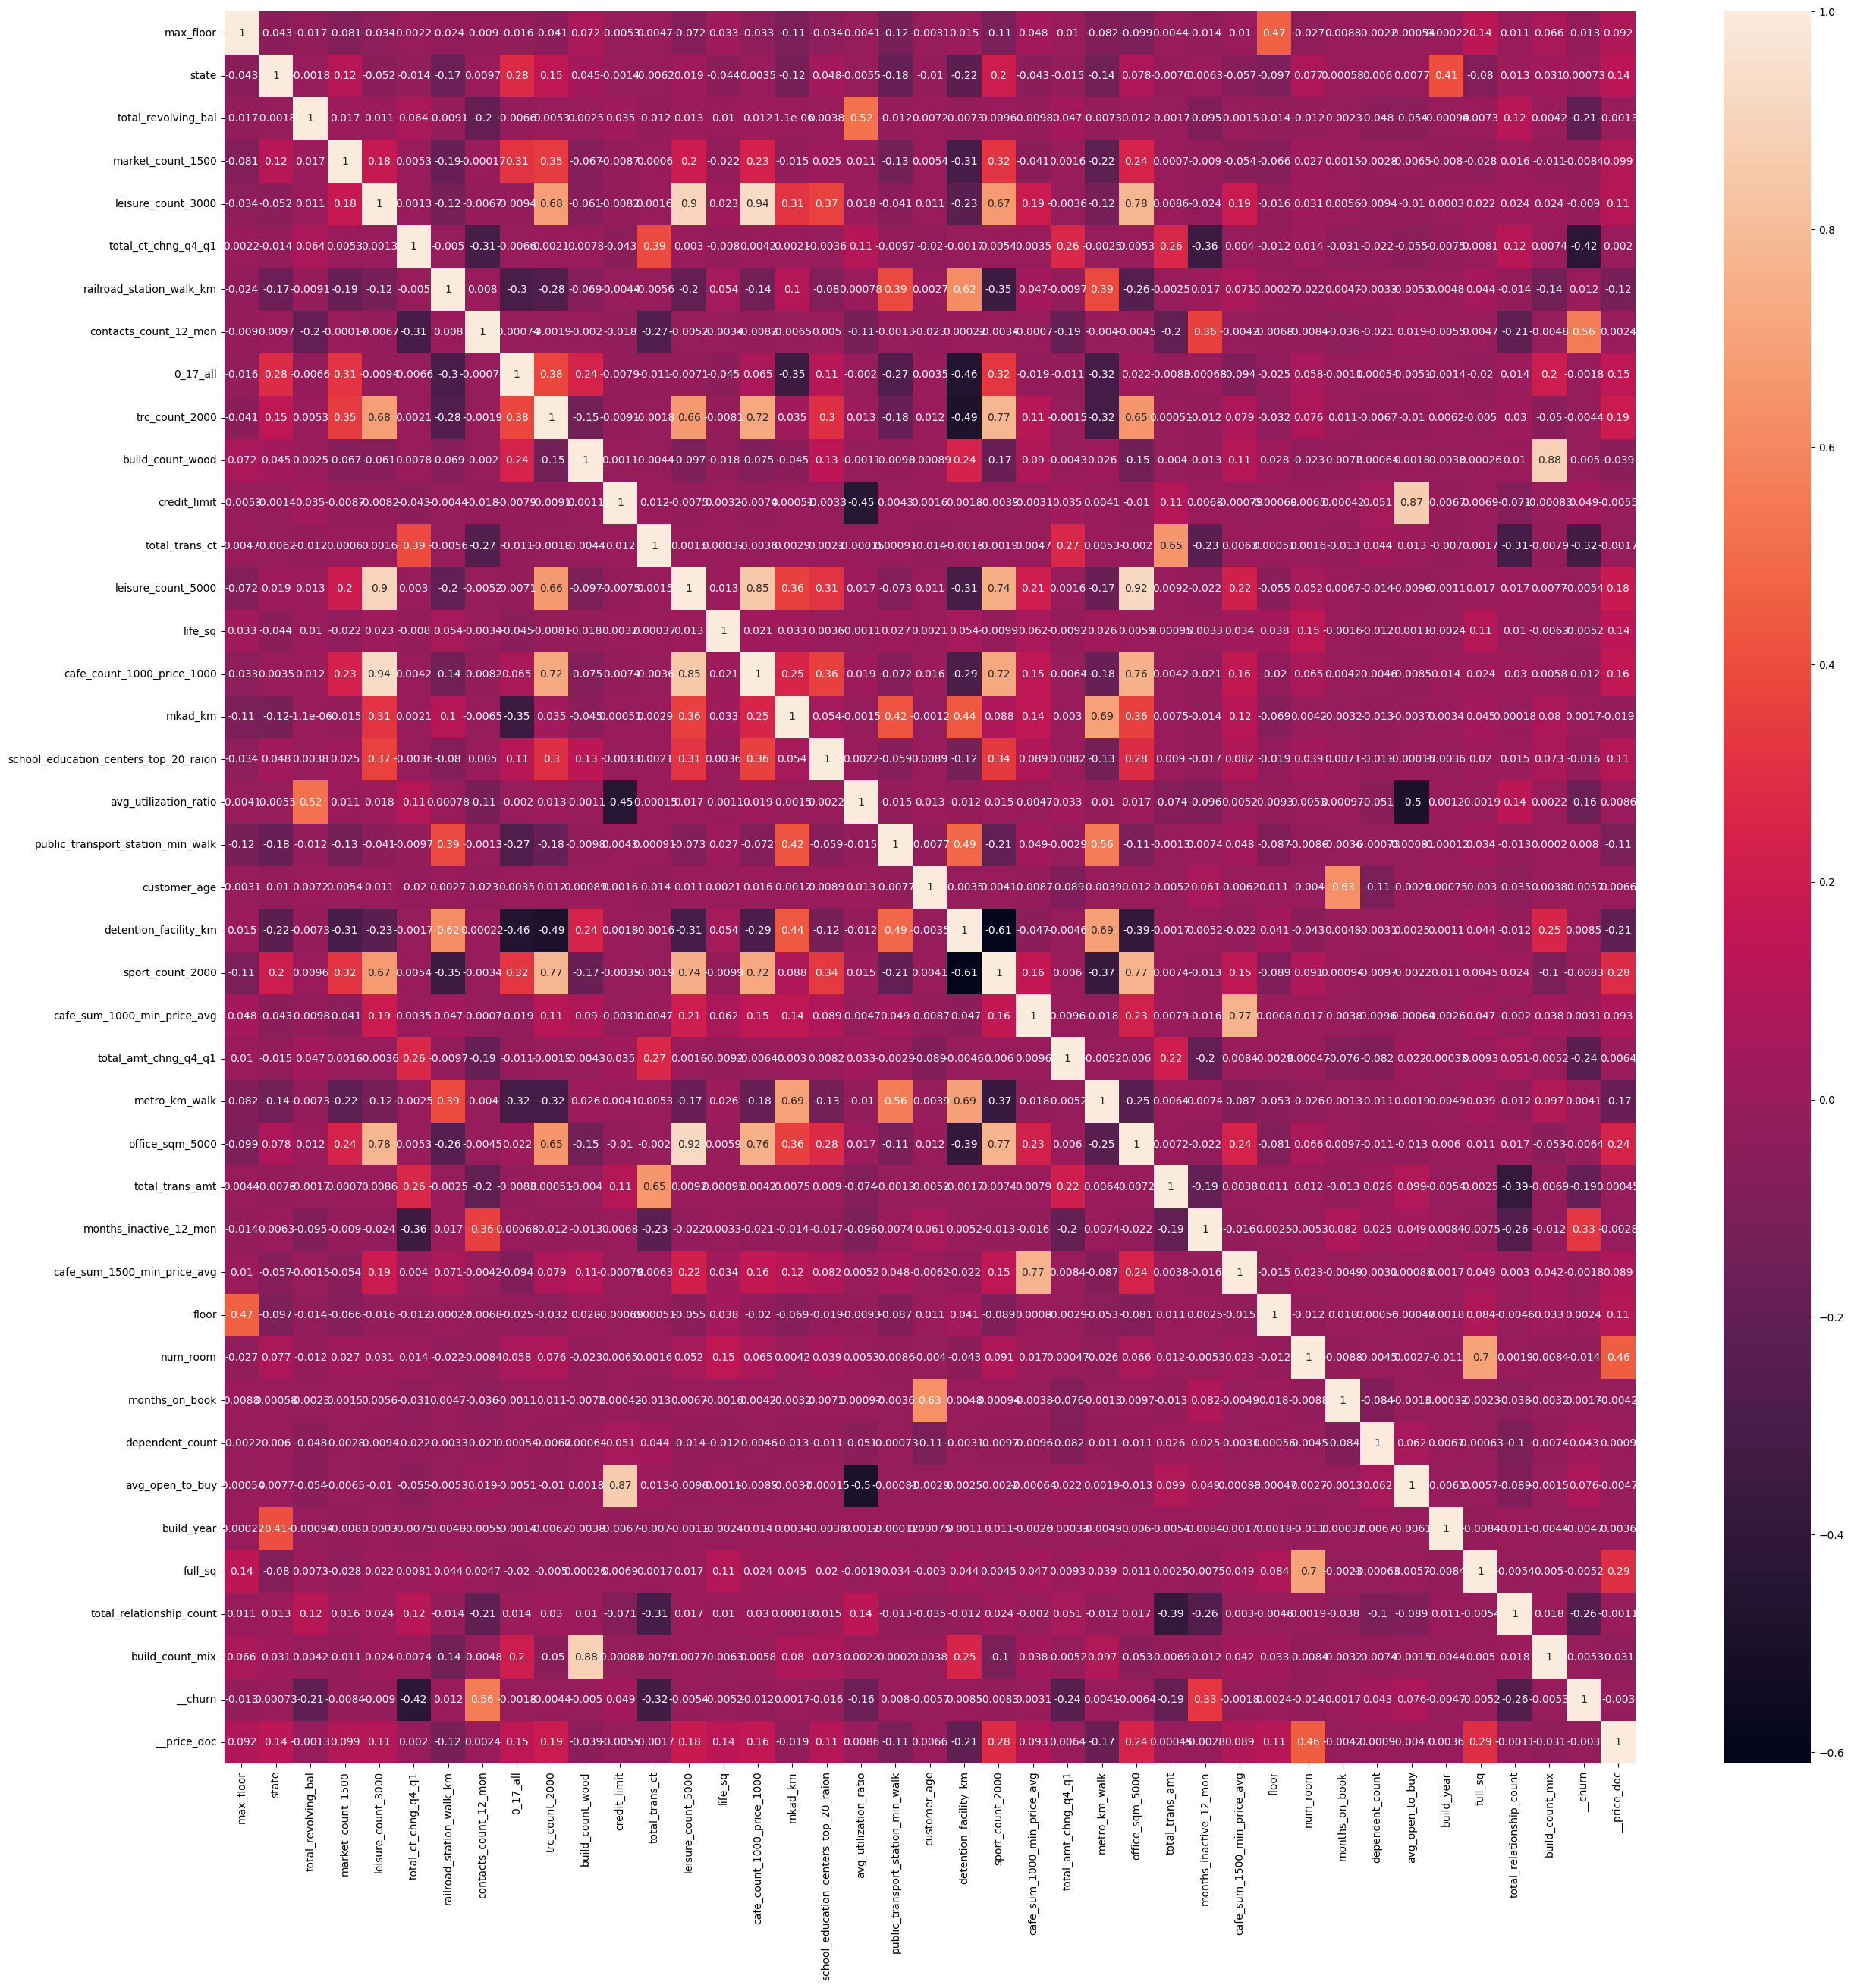

In [ ]:
#Get a correlation heat map
plt.figure(figsize=(30,30)) #get the propersize of the heatmap
sns.heatmap(corr, annot =True) #annot = True includes the values of the correlation relationship

The correlation amongst variables is very low. This means that there is no much collinearity among them.

In [27]:
corr.head().T.head().round(2)

max_floor  state  total_revolving_bal  market_count_1500  \
max_floor                 1.00  -0.04                -0.02              -0.08   
state                    -0.04   1.00                -0.00               0.12   
total_revolving_bal      -0.02  -0.00                 1.00               0.02   
market_count_1500        -0.08   0.12                 0.02               1.00   
leisure_count_3000       -0.03  -0.05                 0.01               0.18   

                     leisure_count_3000  
max_floor                         -0.03  
state                             -0.05  
total_revolving_bal                0.01  
market_count_1500                  0.18  
leisure_count_3000                 1.00

In [ ]:
#checking correlation with our target values
corr['__churn'].abs().sort_values(ascending=False).head(10)

__churn                     1.000000
contacts_count_12_mon       0.555666
total_ct_chng_q4_q1         0.424119
months_inactive_12_mon      0.325025
total_trans_ct              0.322356
total_relationship_count    0.259767
total_amt_chng_q4_q1        0.243586
total_revolving_bal         0.209078
total_trans_amt             0.192359
avg_utilization_ratio       0.164768
Name: __churn, dtype: float64

In [ ]:
corr['__price_doc'].abs().sort_values(ascending=False).head(10)

__price_doc                   1.000000
num_room                      0.458204
full_sq                       0.290589
sport_count_2000              0.278837
office_sqm_5000               0.242210
detention_facility_km         0.208426
trc_count_2000                0.193177
leisure_count_5000            0.183895
metro_km_walk                 0.171779
cafe_count_1000_price_1000    0.157386
Name: __price_doc, dtype: float64

In [ ]:
#finding garbage value
train.select_dtypes(include='object').apply(lambda x: x=='..').sum()

#There are no garbage values


marital_status               0
big_market_raion             0
water_1line                  0
culture_objects_top_25       0
product_type                 0
big_road1_1line              0
card_category                0
income_category              0
thermal_power_plant_raion    0
radiation_raion              0
ecology                      0
gender                       0
oil_chemistry_raion          0
nuclear_reactor_raion        0
railroad_1line               0
timestamp                    0
education_level              0
incineration_raion           0
detention_facility_raion     0
railroad_terminal_raion      0
dtype: int64

In [ ]:

test.select_dtypes(include='object').apply(lambda x: x=='..').sum()

#There are no garbage values

marital_status               0
big_market_raion             0
water_1line                  0
culture_objects_top_25       0
product_type                 0
big_road1_1line              0
card_category                0
income_category              0
thermal_power_plant_raion    0
radiation_raion              0
ecology                      0
gender                       0
oil_chemistry_raion          0
nuclear_reactor_raion        0
railroad_1line               0
timestamp                    0
education_level              0
incineration_raion           0
detention_facility_raion     0
railroad_terminal_raion      0
dtype: int64

In [ ]:
#Checking for duplicates

train.duplicated().sum()

#no duplicates

0

In [ ]:
test.duplicated().sum()

#no duplicates

0

2. DATA PREPROCESSING

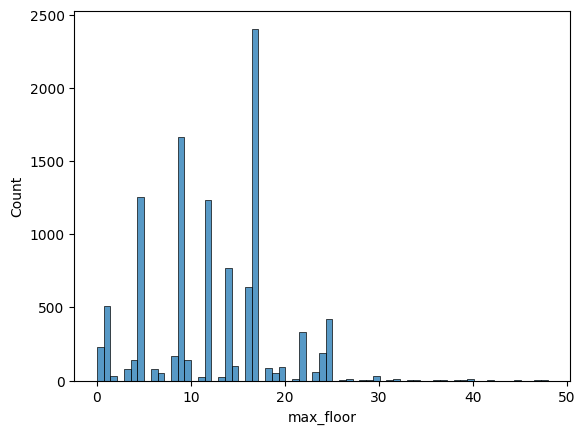

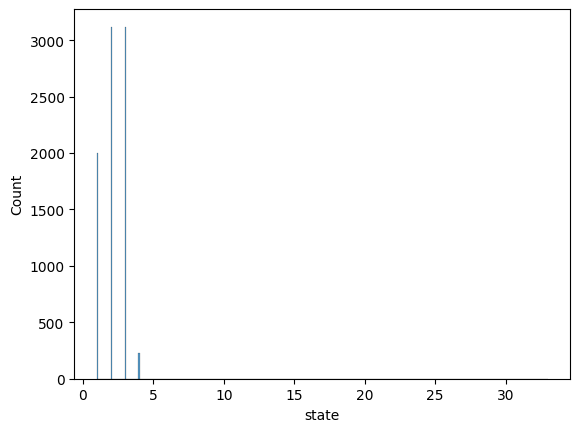

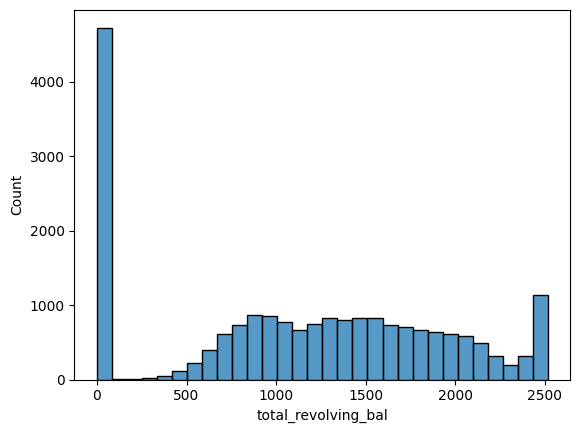

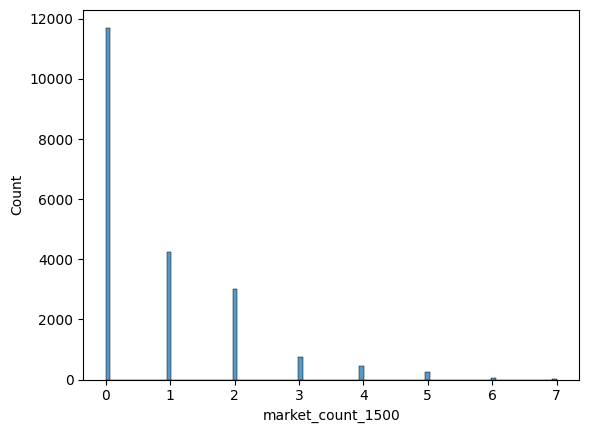

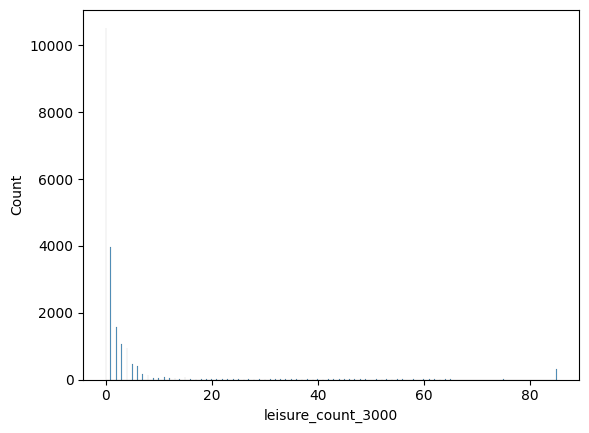

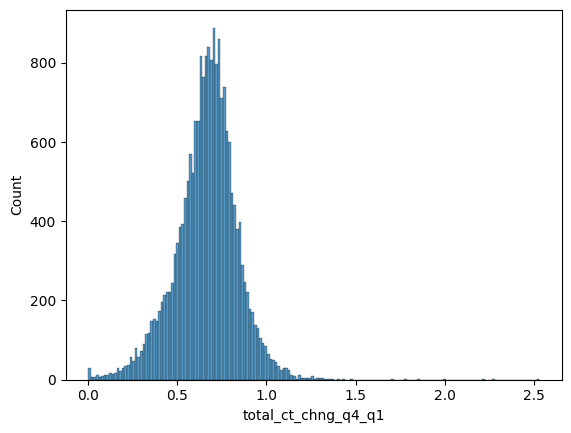

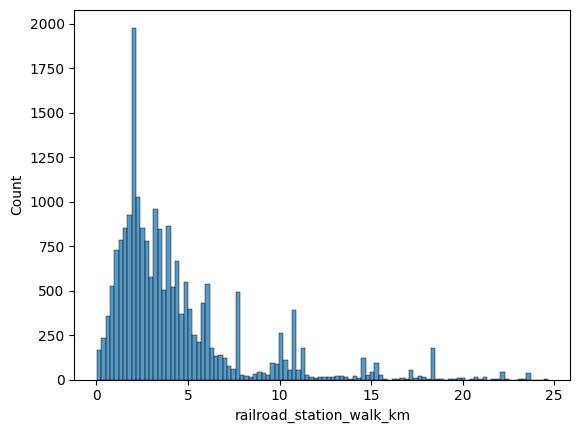

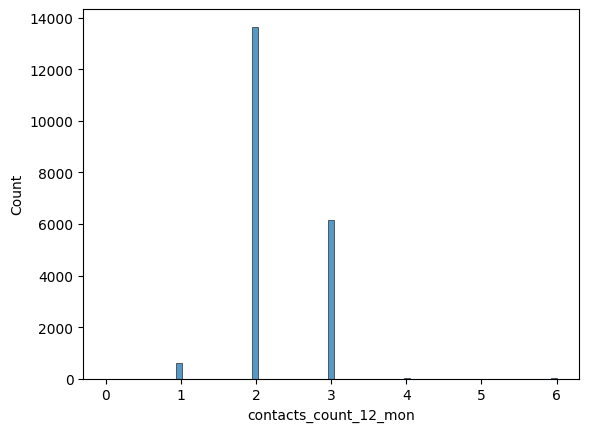

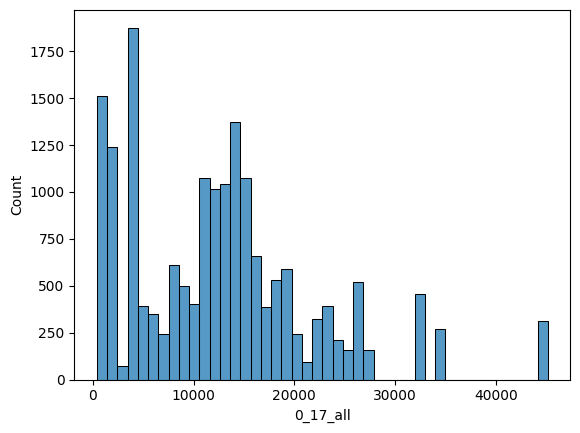

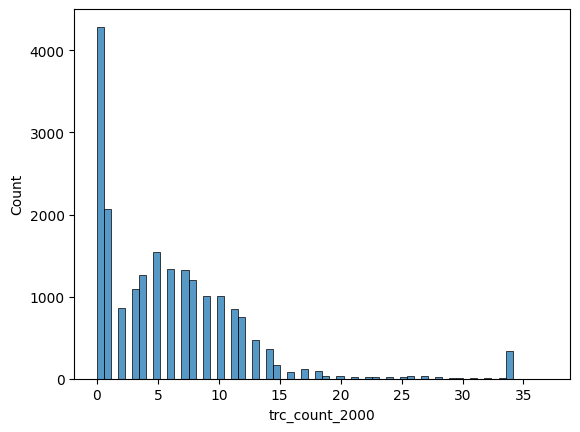

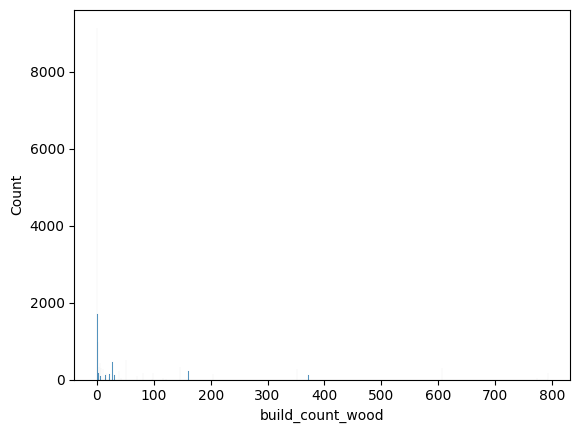

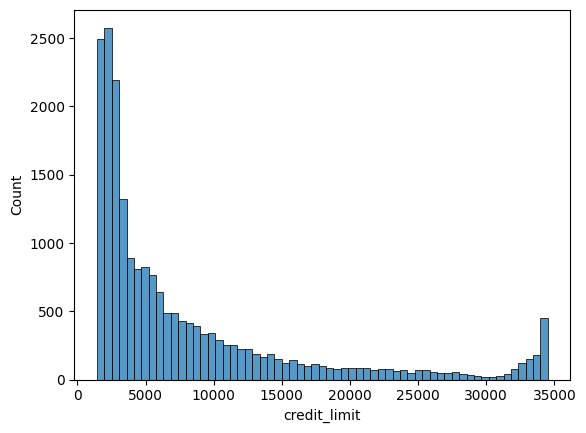

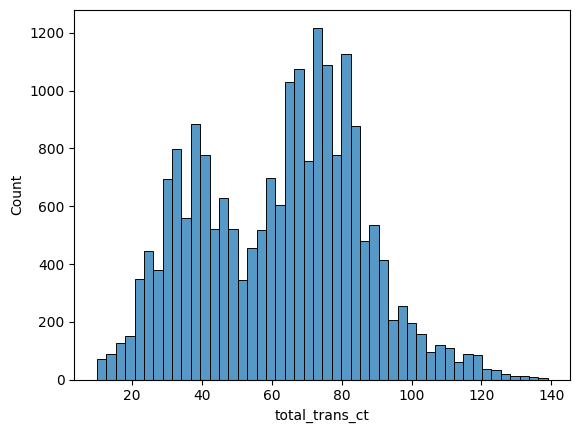

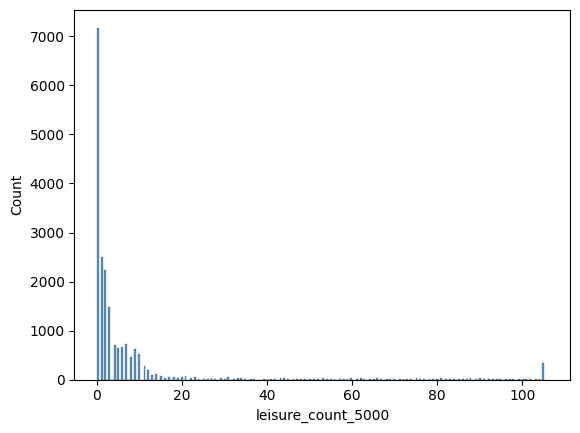

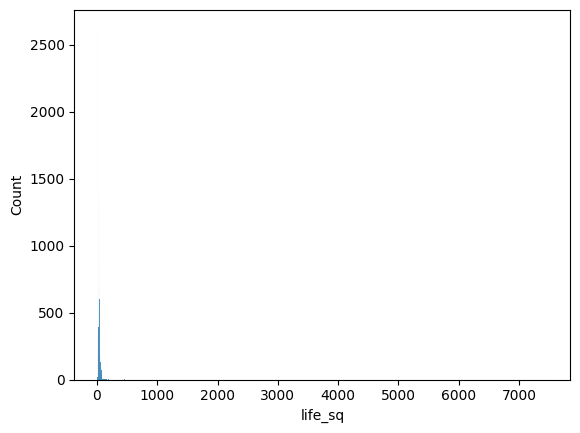

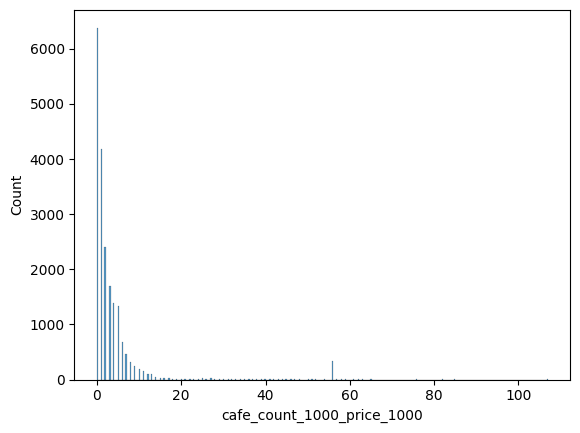

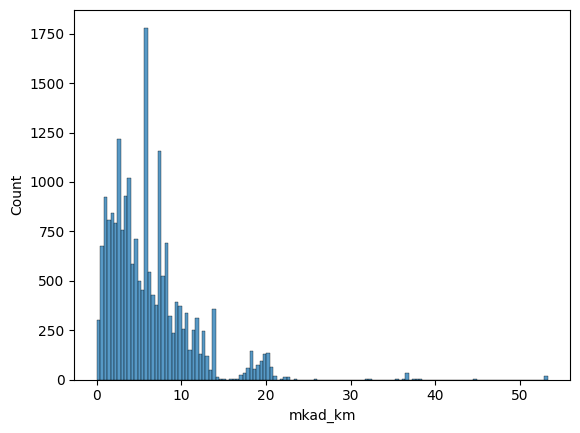

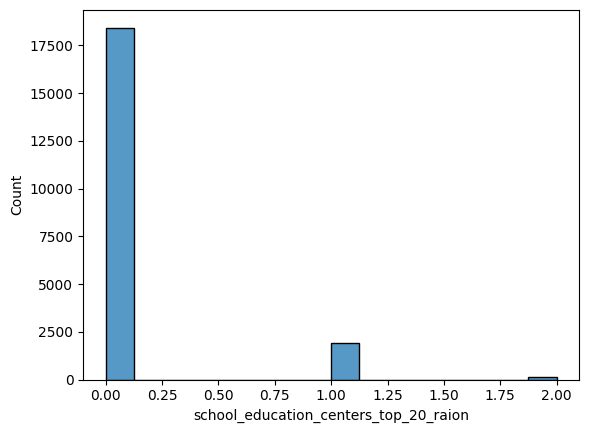

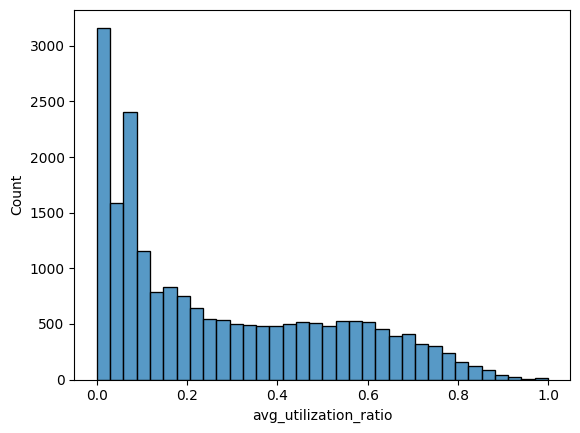

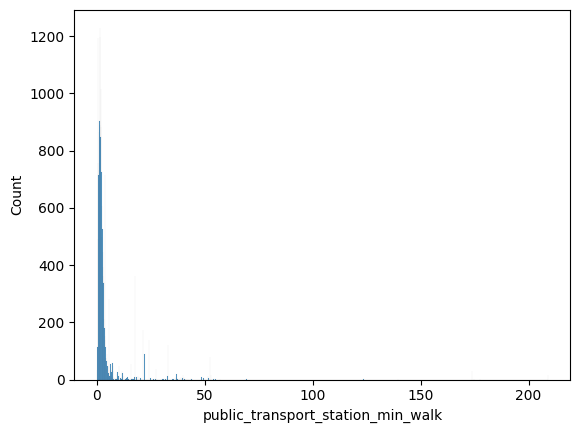

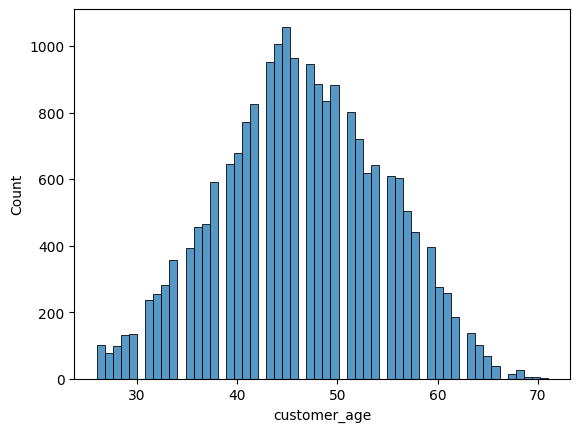

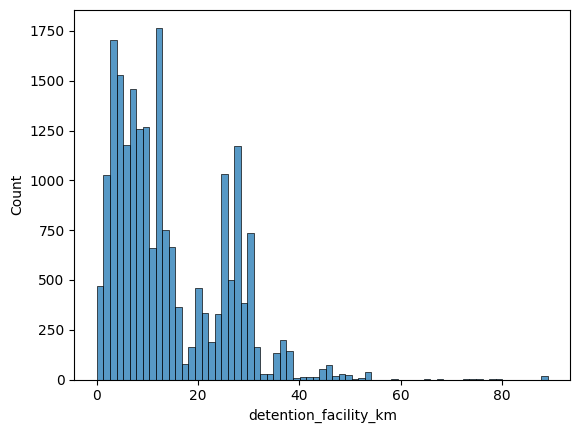

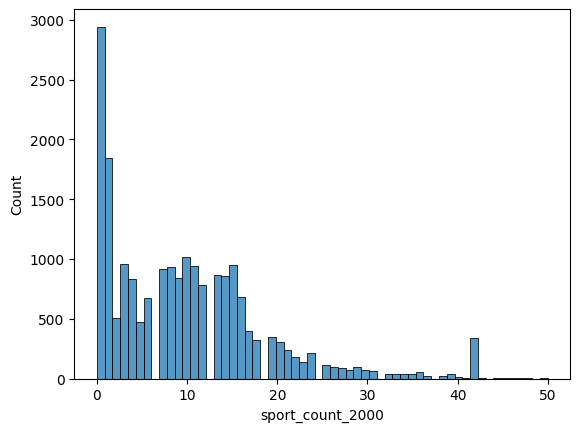

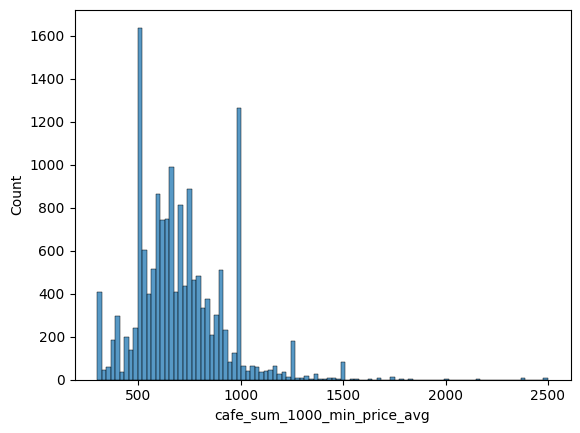

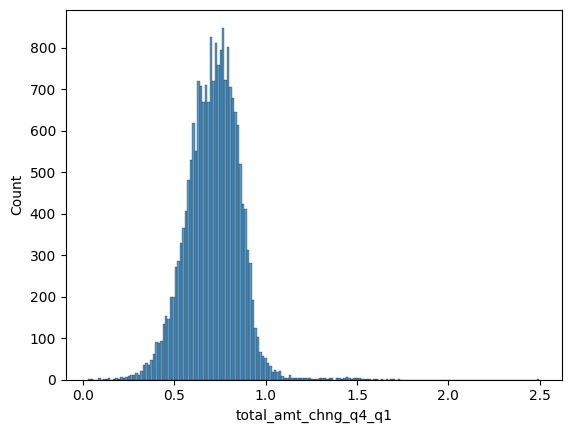

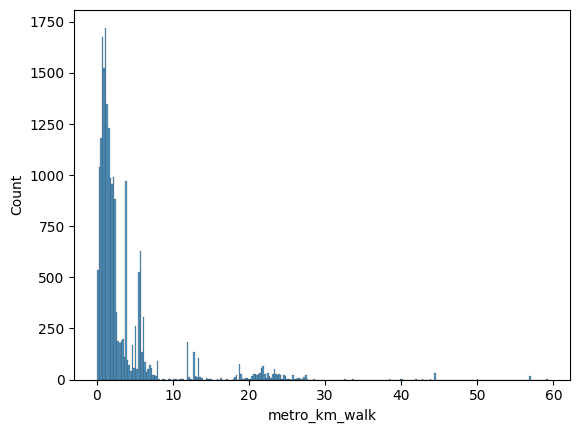

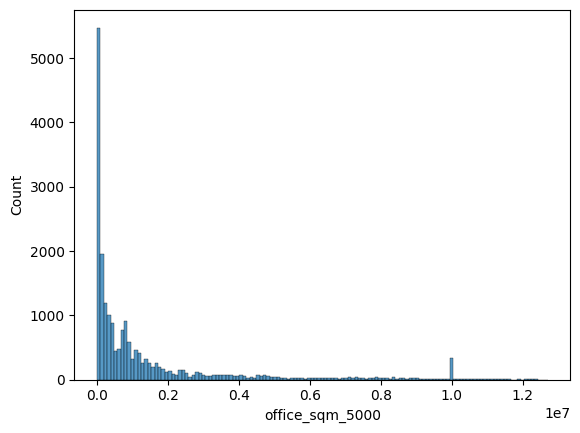

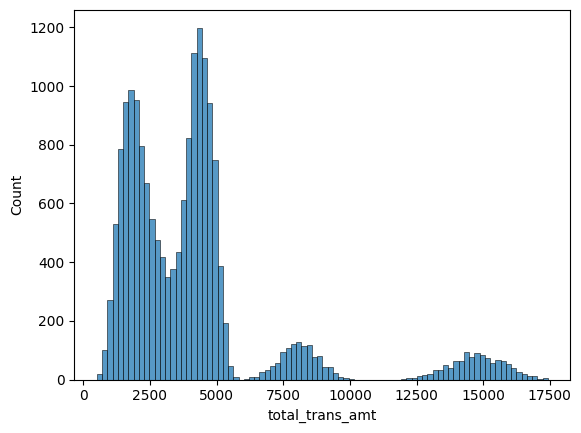

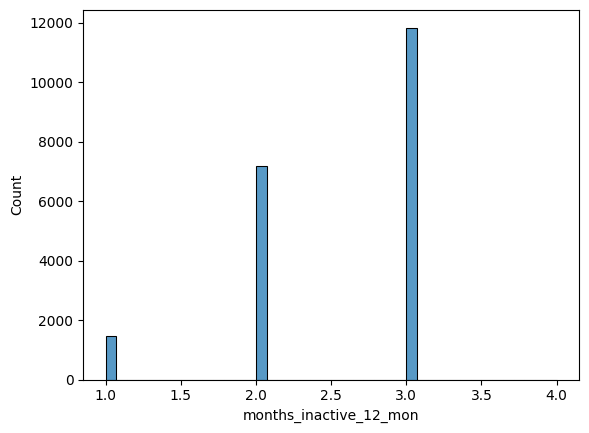

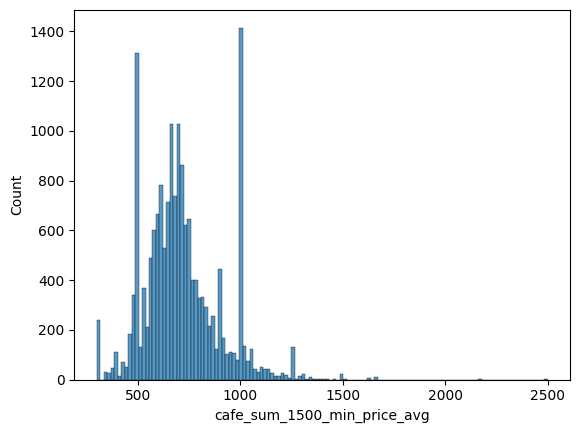

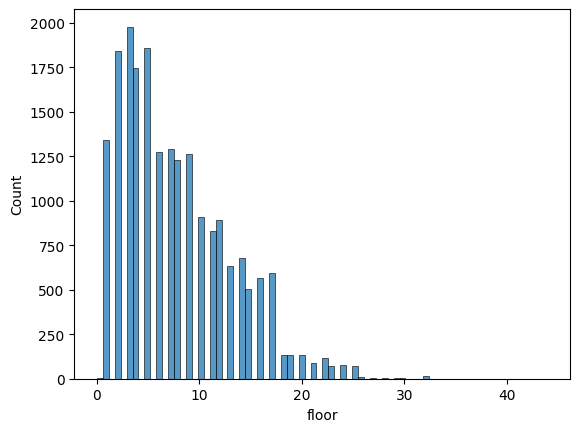

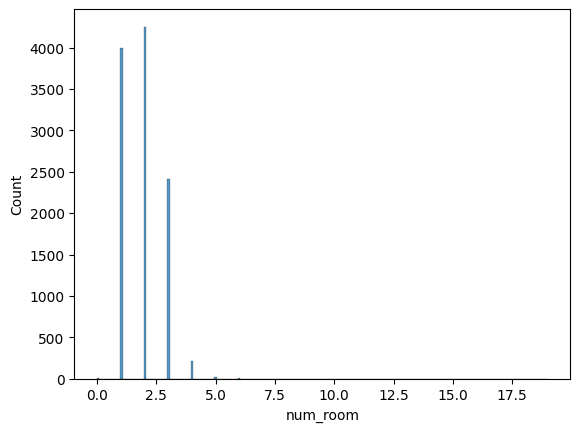

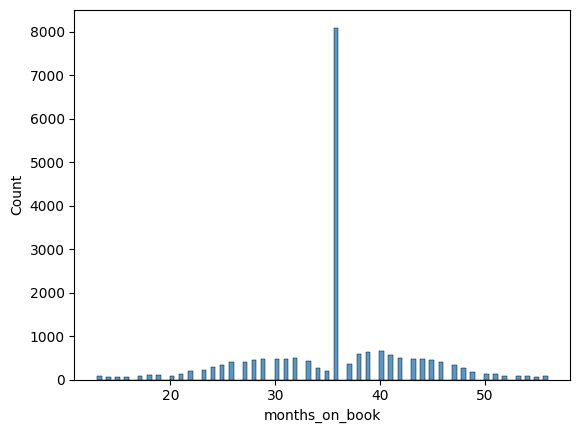

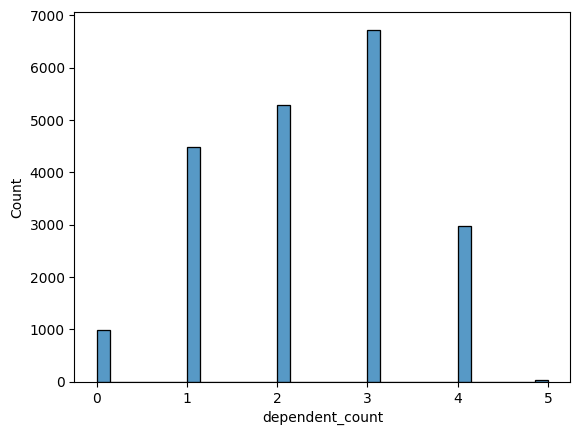

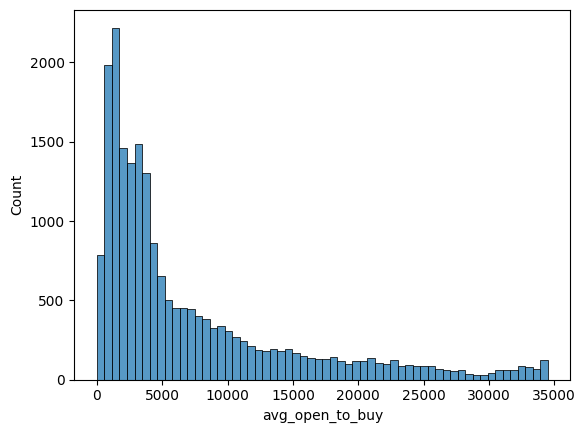

In [ ]:
#histogram to undestand the distribution of the data
import warnings
warnings.filterwarnings('ignore')

for i in train.select_dtypes(include = 'number').columns:
  sns.histplot(data = train, x = i)
  plt.xlabel
  plt.show()



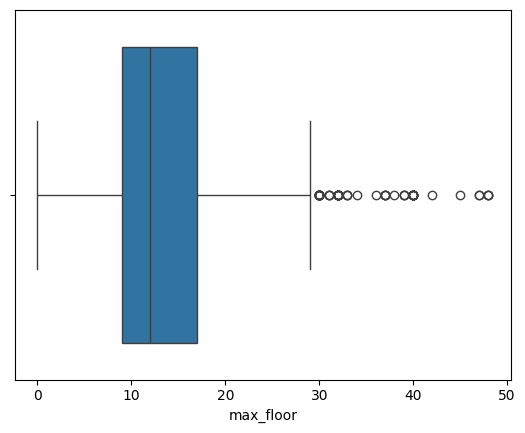

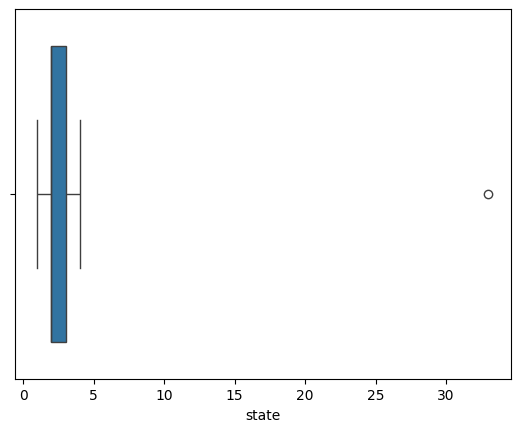

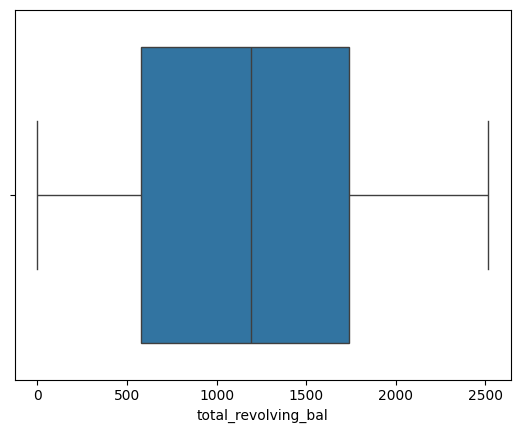

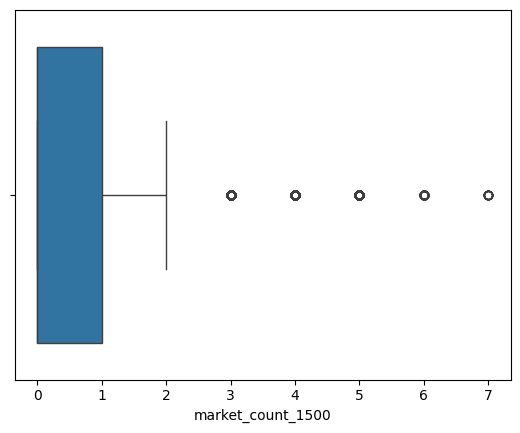

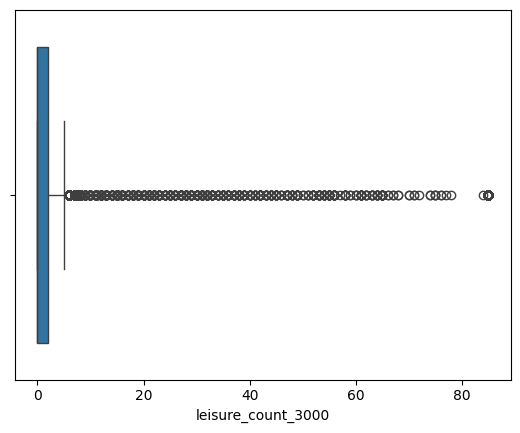

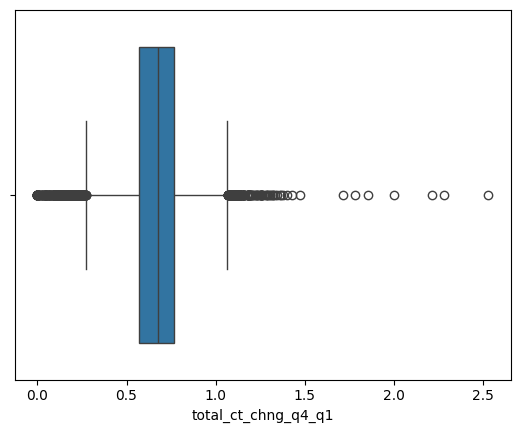

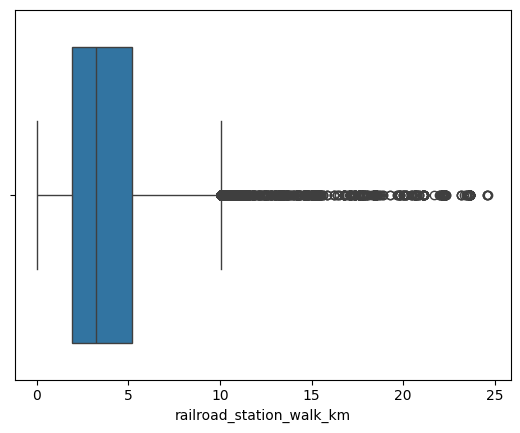

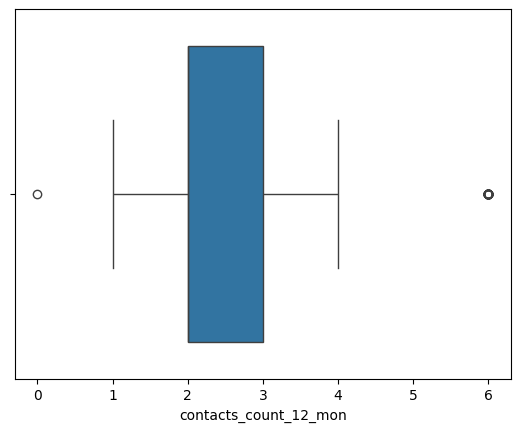

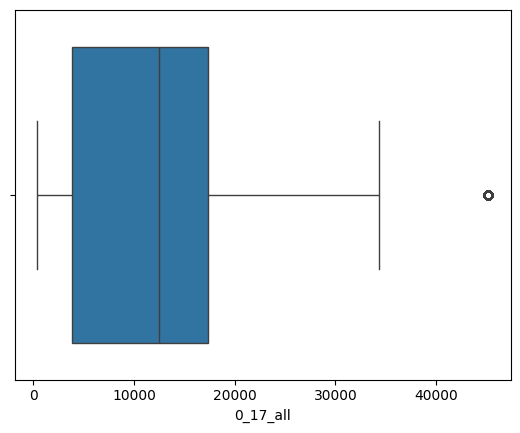

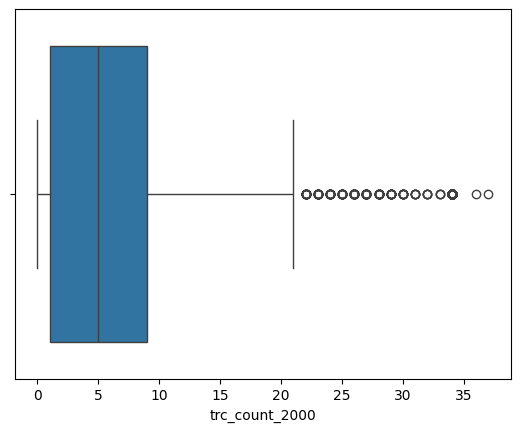

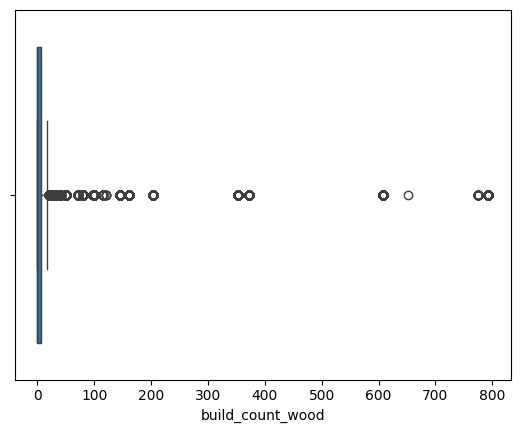

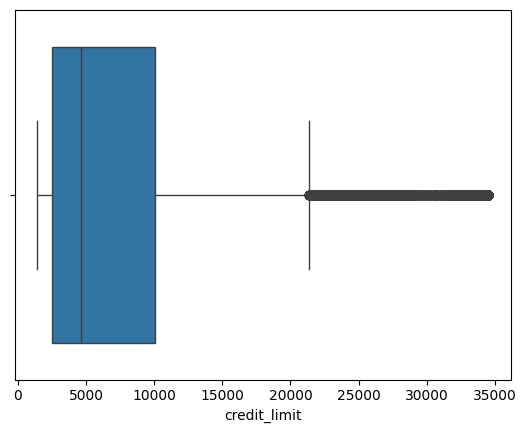

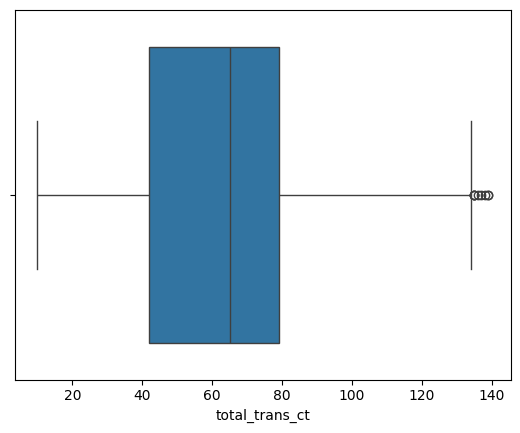

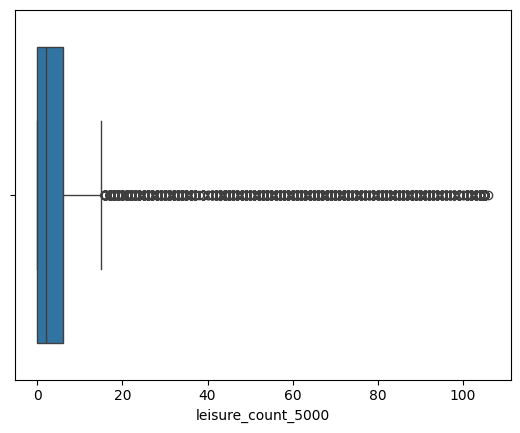

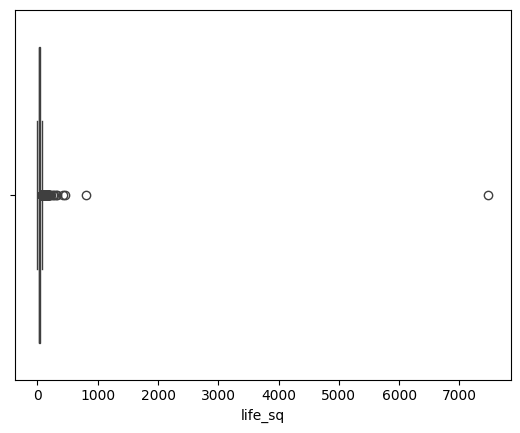

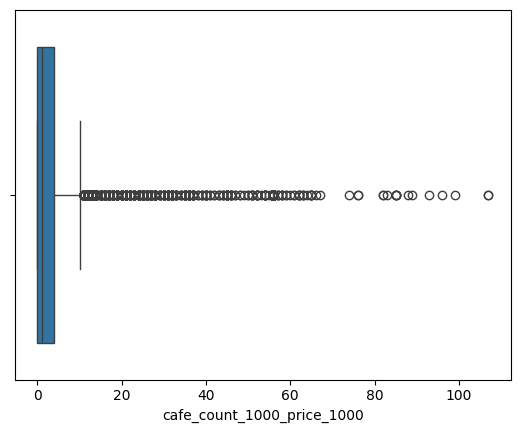

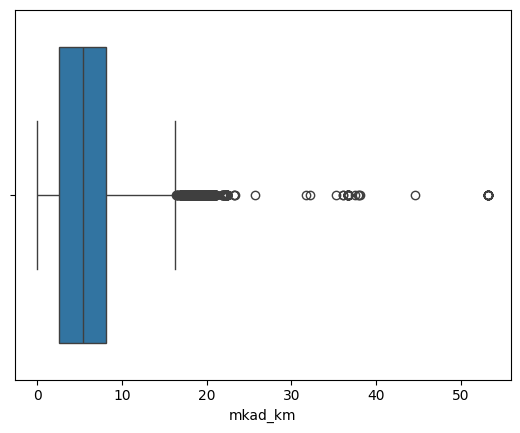

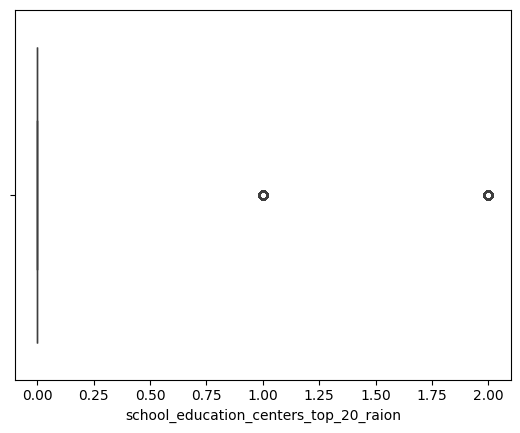

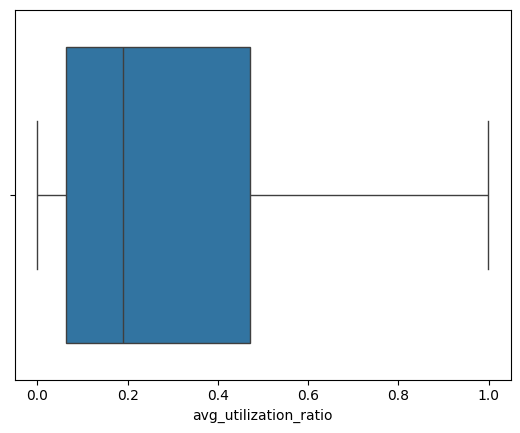

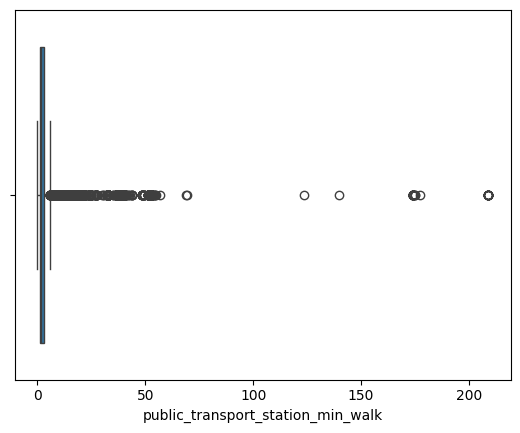

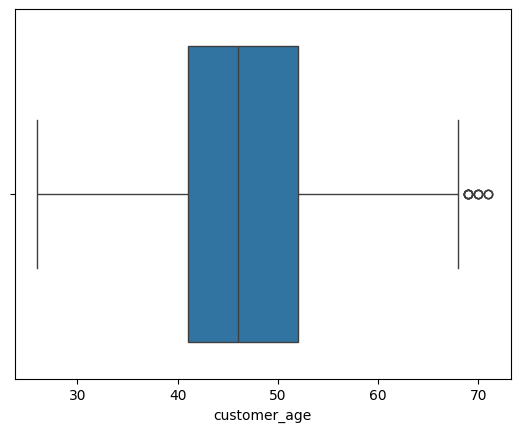

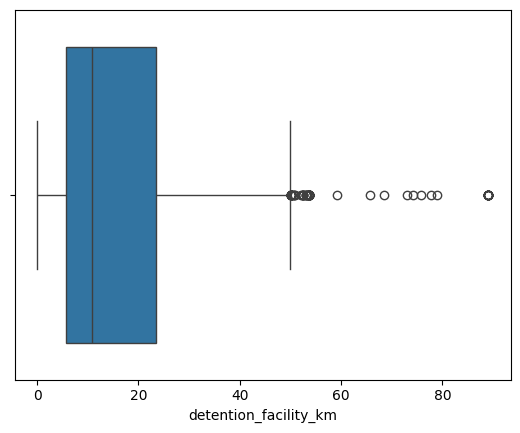

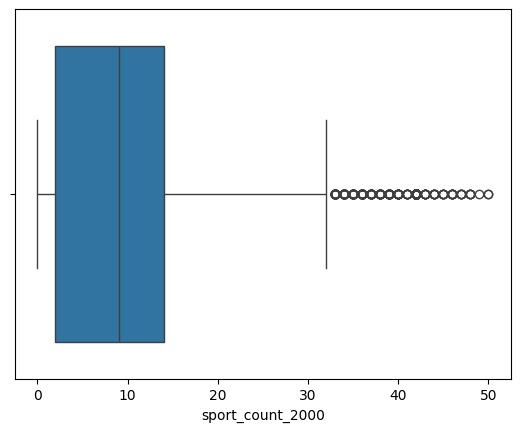

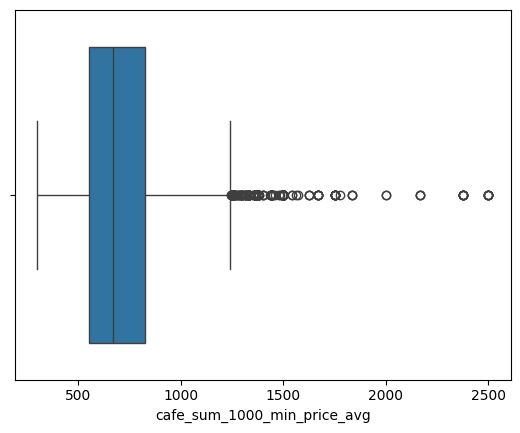

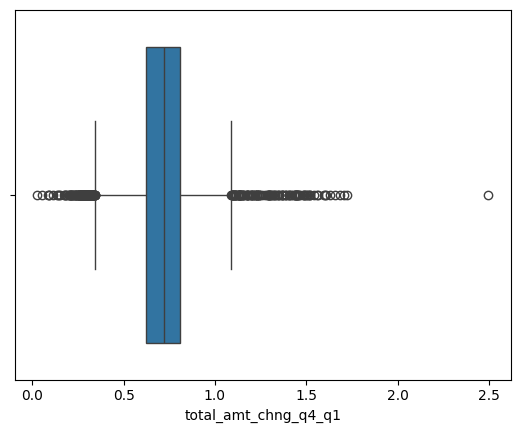

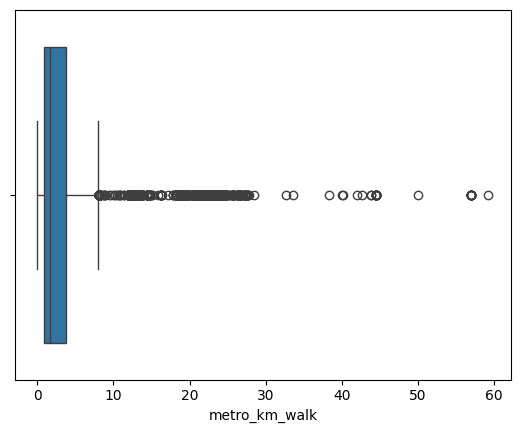

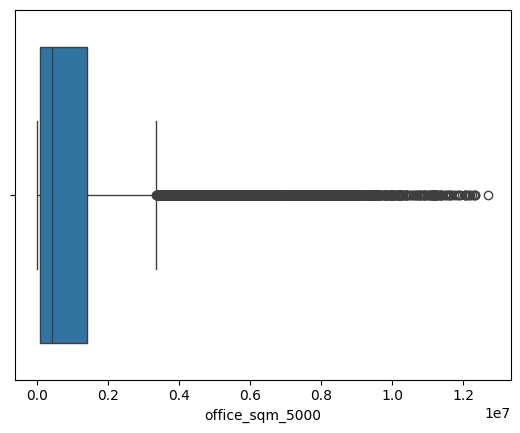

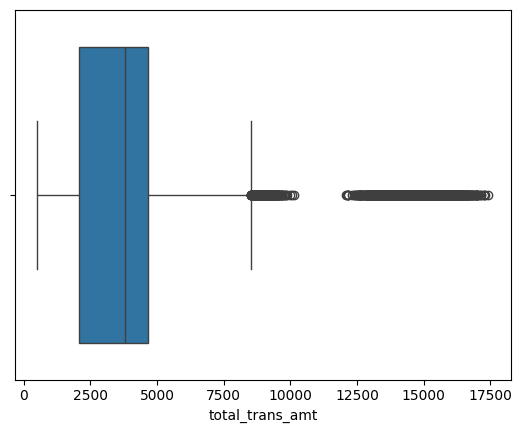

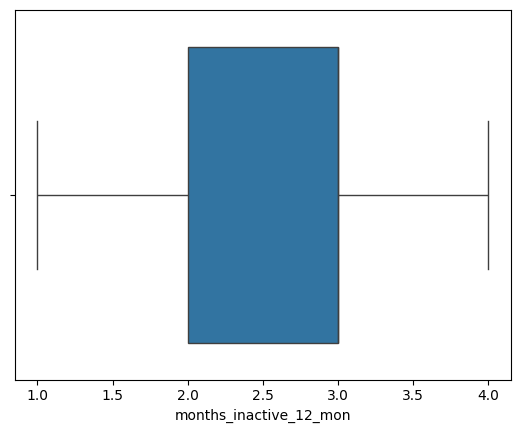

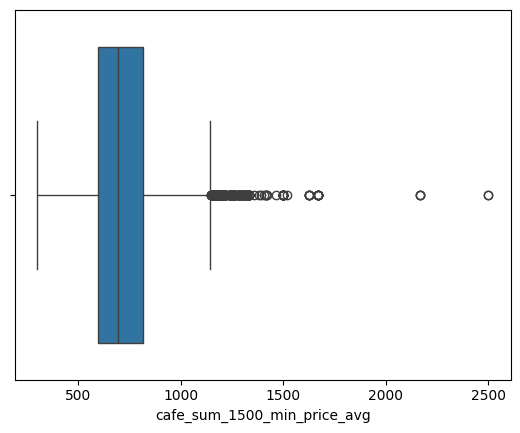

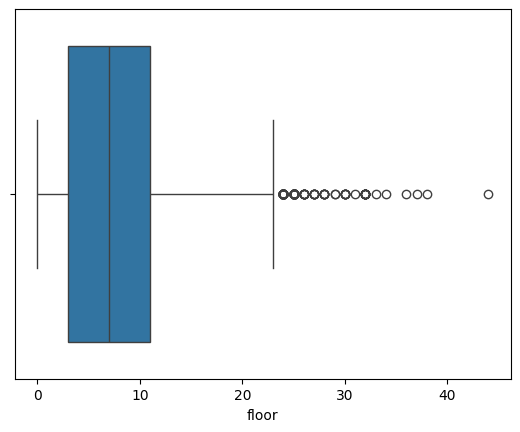

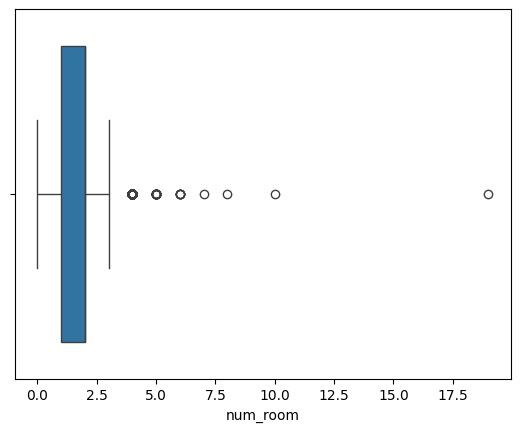

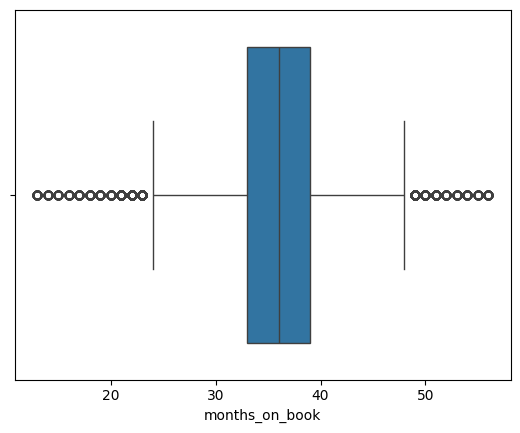

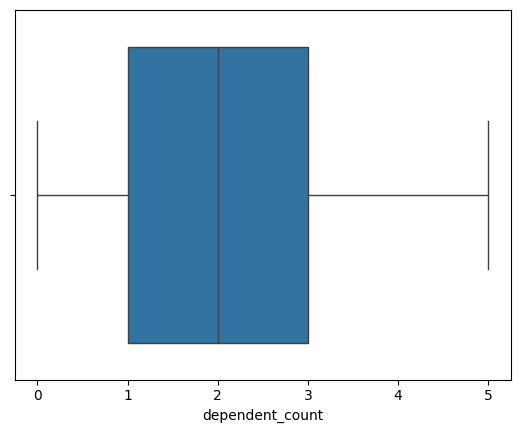

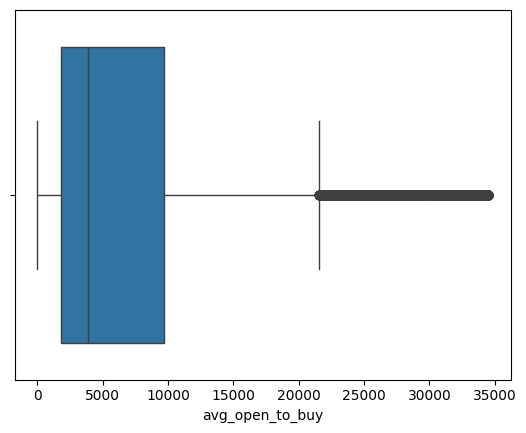

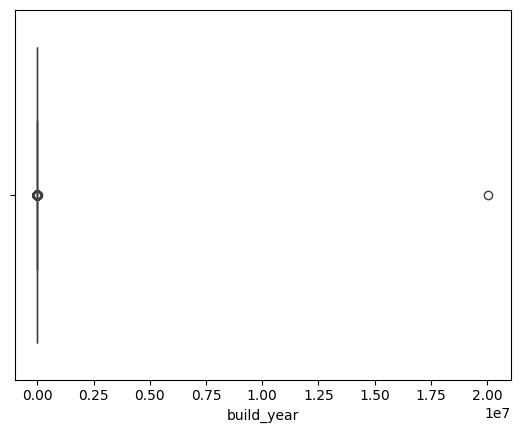

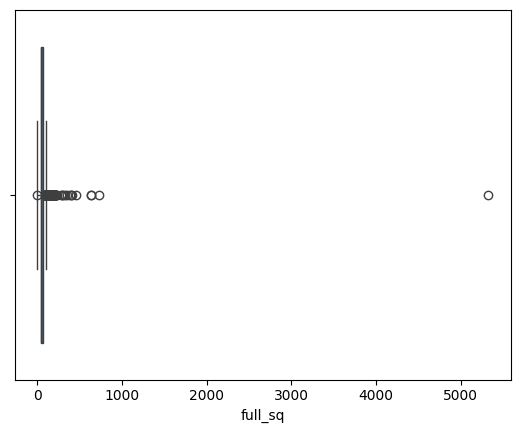

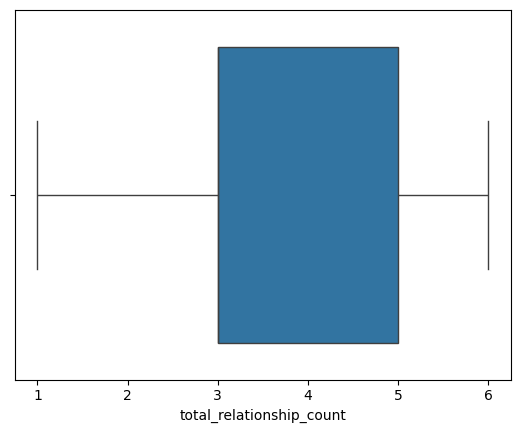

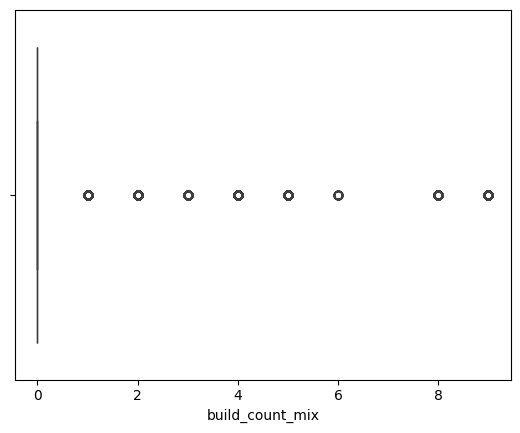

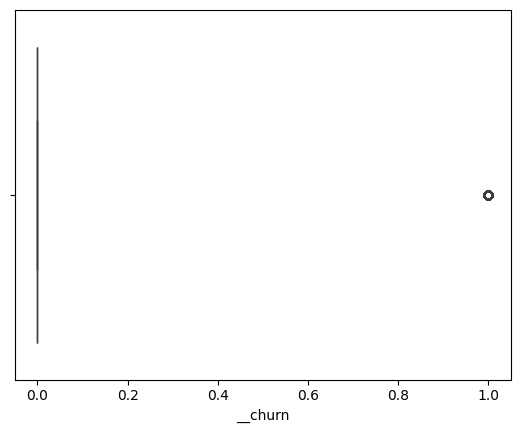

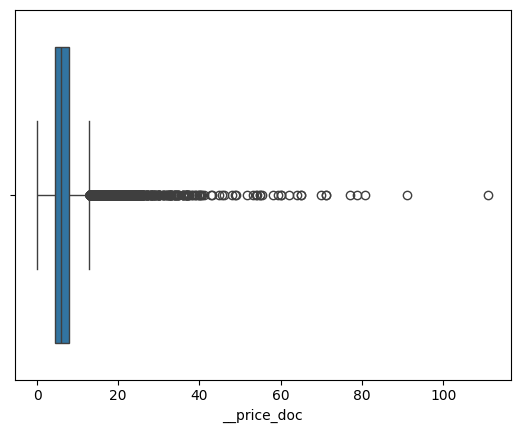

In [ ]:
#checking for outliers using boxplots
for i in train.select_dtypes(include = 'number').columns:
  sns.boxplot(data = train, x = i)
  plt.xlabel
  plt.show()


2.1 Dealing with missing values

In [ ]:
#get the percentage of missing values per column
train.isnull().sum().sort_values(ascending = False)/train.shape[0]*100

state                                    58.653518
build_year                               56.544451
num_room                                 46.731436
max_floor                                46.731436
cafe_sum_1000_min_price_avg              22.438119
life_sq                                  20.470634
build_count_mix                          14.953864
build_count_wood                         14.953864
cafe_sum_1500_min_price_avg              14.636528
total_trans_amt                          11.731680
0_17_all                                 11.731680
floor                                     0.815310
metro_km_walk                             0.048821
railroad_station_walk_km                  0.048821
nuclear_reactor_raion                     0.000000
railroad_1line                            0.000000
months_inactive_12_mon                    0.000000
oil_chemistry_raion                       0.000000
gender                                    0.000000
ecology                                   0.000000
office_sqm_5000                           0.000000
education_level                           0.000000
timestamp                                 0.000000
months_on_book                            0.000000
dependent_count                           0.000000
avg_open_to_buy                           0.000000
incineration_raion                        0.000000
full_sq                                   0.000000
total_relationship_count                  0.000000
detention_facility_raion                  0.000000
railroad_terminal_raion                   0.000000
__churn                                   0.000000
total_amt_chng_q4_q1                      0.000000
radiation_raion                           0.000000
sport_count_2000                          0.000000
credit_limit                              0.000000
marital_status                            0.000000
big_market_raion                          0.000000
total_revolving_bal                       0.000000
market_count_1500                         0.000000
leisure_count_3000                        0.000000
total_ct_chng_q4_q1                       0.000000
water_1line                               0.000000
culture_objects_top_25                    0.000000
contacts_count_12_mon                     0.000000
trc_count_2000                            0.000000
product_type                              0.000000
total_trans_ct                            0.000000
detention_facility_km                     0.000000
leisure_count_5000                        0.000000
cafe_count_1000_price_1000                0.000000
mkad_km                                   0.000000
school_education_centers_top_20_raion     0.000000
big_road1_1line                           0.000000
card_category                             0.000000
avg_utilization_ratio                     0.000000
public_transport_station_min_walk         0.000000
income_category                           0.000000
customer_age                              0.000000
thermal_power_plant_raion                 0.000000
__price_doc                               0.000000
dtype: float64

In [7]:
test.isnull().sum().sort_values(ascending = False)/train.shape[0]*100

total_trans_amt                          44.832300
0_17_all                                 44.832300
life_sq                                   9.832544
build_year                                9.100229
build_count_mix                           8.724308
build_count_wood                          8.724308
cafe_sum_1000_min_price_avg               8.675487
state                                     6.908168
cafe_sum_1500_min_price_avg               5.419128
railroad_station_walk_km                  0.063467
metro_km_walk                             0.063467
f_state                                   0.000000
f_life_sq                                 0.000000
f_cafe_sum_1500_min_price_avg             0.000000
months_inactive_12_mon                    0.000000
f_build_count_wood                        0.000000
railroad_1line                            0.000000
f_build_count_mix                         0.000000
floor                                     0.000000
num_room                                  0.000000
timestamp                                 0.000000
education_level                           0.000000
months_on_book                            0.000000
dependent_count                           0.000000
avg_open_to_buy                           0.000000
incineration_raion                        0.000000
f_railroad_station_walk_km                0.000000
full_sq                                   0.000000
total_relationship_count                  0.000000
detention_facility_raion                  0.000000
f_cafe_sum_1000_min_price_avg             0.000000
oil_chemistry_raion                       0.000000
railroad_terminal_raion                   0.000000
f_floor                                   0.000000
f_max_floor                               0.000000
f_num_room                                0.000000
f_0_17_all                                0.000000
f_metro_km_walk                           0.000000
f_build_year                              0.000000
nuclear_reactor_raion                     0.000000
Unnamed: 0                                0.000000
gender                                    0.000000
cafe_count_1000_price_1000                0.000000
marital_status                            0.000000
big_market_raion                          0.000000
total_revolving_bal                       0.000000
market_count_1500                         0.000000
leisure_count_3000                        0.000000
total_ct_chng_q4_q1                       0.000000
water_1line                               0.000000
culture_objects_top_25                    0.000000
contacts_count_12_mon                     0.000000
trc_count_2000                            0.000000
product_type                              0.000000
credit_limit                              0.000000
total_trans_ct                            0.000000
leisure_count_5000                        0.000000
mkad_km                                   0.000000
office_sqm_5000                           0.000000
school_education_centers_top_20_raion     0.000000
big_road1_1line                           0.000000
card_category                             0.000000
avg_utilization_ratio                     0.000000
public_transport_station_min_walk         0.000000
income_category                           0.000000
customer_age                              0.000000
thermal_power_plant_raion                 0.000000
radiation_raion                           0.000000
detention_facility_km                     0.000000
sport_count_2000                          0.000000
total_amt_chng_q4_q1                      0.000000
ecology                                   0.000000
max_floor                                 0.000000
f_total_trans_amt                         0.000000
dtype: float64

In [28]:
#replacing missing values with the median

for i in ['floor', 'max_floor','0_17_all', 'metro_km_walk', 'railroad_station_walk_km']:
  imputer = SimpleImputer(strategy='median')

# fit instance and transform train_median
  train[f'f_{i}'] = imputer.fit_transform(train[[i]])
  test[f'f_{i}'] = imputer.transform(test[[i]])


In [29]:
#replacing missing values with the mode

#select more columns with missing values
fetures_train = ['state','build_year','num_room','cafe_sum_1000_min_price_avg',
'life_sq','build_count_mix','build_count_wood','cafe_sum_1500_min_price_avg',
'total_trans_amt'	]
features_test = ['state','build_year','num_room','cafe_sum_1000_min_price_avg',
'life_sq','build_count_mix','build_count_wood','cafe_sum_1500_min_price_avg',
'total_trans_amt'	]

#create an imputer for the mode
imputer = SimpleImputer(strategy='most_frequent')

#fit the imputer on the selected training features
for i in fetures_train:
  # Fit the imputer to the train data
  imputer.fit(train[[i]])

#transform the train and test data
  train[f'f_{i}'] = imputer.transform(train[[i]]).ravel()  # Flatten the 2D array to 1D
  test[f'f_{i}'] = imputer.transform(test[[i]]).ravel()

In [6]:
train.isnull().sum().sort_values(ascending = False )

state                                    12014
build_year                               11582
max_floor                                 9572
num_room                                  9572
cafe_sum_1000_min_price_avg               4596
life_sq                                   4193
build_count_wood                          3063
build_count_mix                           3063
cafe_sum_1500_min_price_avg               2998
0_17_all                                  2403
total_trans_amt                           2403
floor                                      167
railroad_station_walk_km                    10
metro_km_walk                               10
timestamp                                    0
total_relationship_count                     0
months_on_book                               0
dependent_count                              0
avg_open_to_buy                              0
railroad_1line                               0
incineration_raion                           0
full_sq                                      0
education_level                              0
__churn                                      0
detention_facility_raion                     0
f_build_year                                 0
f_cafe_sum_1500_min_price_avg                0
f_build_count_wood                           0
f_build_count_mix                            0
f_life_sq                                    0
f_cafe_sum_1000_min_price_avg                0
f_num_room                                   0
f_state                                      0
railroad_terminal_raion                      0
f_railroad_station_walk_km                   0
f_metro_km_walk                              0
f_0_17_all                                   0
f_max_floor                                  0
f_floor                                      0
__price_doc                                  0
months_inactive_12_mon                       0
office_sqm_5000                              0
nuclear_reactor_raion                        0
cafe_count_1000_price_1000                   0
marital_status                               0
big_market_raion                             0
total_revolving_bal                          0
market_count_1500                            0
leisure_count_3000                           0
total_ct_chng_q4_q1                          0
water_1line                                  0
culture_objects_top_25                       0
contacts_count_12_mon                        0
trc_count_2000                               0
product_type                                 0
credit_limit                                 0
total_trans_ct                               0
leisure_count_5000                           0
mkad_km                                      0
oil_chemistry_raion                          0
school_education_centers_top_20_raion        0
big_road1_1line                              0
card_category                                0
avg_utilization_ratio                        0
public_transport_station_min_walk            0
income_category                              0
customer_age                                 0
thermal_power_plant_raion                    0
radiation_raion                              0
detention_facility_km                        0
sport_count_2000                             0
total_amt_chng_q4_q1                         0
ecology                                      0
gender                                       0
f_total_trans_amt                            0
dtype: int64

In [10]:
test.isnull().sum().sort_values(ascending = False )

total_trans_amt                          9183
0_17_all                                 9183
life_sq                                  2014
build_year                               1864
build_count_mix                          1787
build_count_wood                         1787
cafe_sum_1000_min_price_avg              1777
state                                    1415
cafe_sum_1500_min_price_avg              1110
railroad_station_walk_km                   13
metro_km_walk                              13
f_state                                     0
f_life_sq                                   0
f_cafe_sum_1500_min_price_avg               0
months_inactive_12_mon                      0
f_build_count_wood                          0
railroad_1line                              0
f_build_count_mix                           0
floor                                       0
num_room                                    0
timestamp                                   0
education_level                             0
months_on_book                              0
dependent_count                             0
avg_open_to_buy                             0
incineration_raion                          0
f_railroad_station_walk_km                  0
full_sq                                     0
total_relationship_count                    0
detention_facility_raion                    0
f_cafe_sum_1000_min_price_avg               0
oil_chemistry_raion                         0
railroad_terminal_raion                     0
f_floor                                     0
f_max_floor                                 0
f_num_room                                  0
f_0_17_all                                  0
f_metro_km_walk                             0
f_build_year                                0
nuclear_reactor_raion                       0
Unnamed: 0                                  0
gender                                      0
cafe_count_1000_price_1000                  0
marital_status                              0
big_market_raion                            0
total_revolving_bal                         0
market_count_1500                           0
leisure_count_3000                          0
total_ct_chng_q4_q1                         0
water_1line                                 0
culture_objects_top_25                      0
contacts_count_12_mon                       0
trc_count_2000                              0
product_type                                0
credit_limit                                0
total_trans_ct                              0
leisure_count_5000                          0
mkad_km                                     0
office_sqm_5000                             0
school_education_centers_top_20_raion       0
big_road1_1line                             0
card_category                               0
avg_utilization_ratio                       0
public_transport_station_min_walk           0
income_category                             0
customer_age                                0
thermal_power_plant_raion                   0
radiation_raion                             0
detention_facility_km                       0
sport_count_2000                            0
total_amt_chng_q4_q1                        0
ecology                                     0
max_floor                                   0
f_total_trans_amt                           0
dtype: int64

*All empty cells have been filled in*

**2.2 Transforming categorical data into numberic**

In [ ]:
#check all object variables
train.select_dtypes(include = 'object').T

0            1            2      \
marital_status                     Single      Married      Married   
big_market_raion                       no           no           no   
water_1line                            no           no           no   
culture_objects_top_25                 no          yes           no   
product_type                   Investment   Investment   Investment   
big_road1_1line                        no           no           no   
card_category                        Blue         Blue         Blue   
income_category            Less than $40K  $40K - $60K  $40K - $60K   
thermal_power_plant_raion              no           no           no   
radiation_raion                        no           no          yes   
ecology                              good    excellent         poor   
gender                                  F            M            F   
oil_chemistry_raion                    no           no           no   
nuclear_reactor_raion                  no           no           no   
railroad_1line                         no           no           no   
timestamp                      2011-08-20   2011-08-23   2011-08-27   
education_level                  Graduate     Graduate     Graduate   
incineration_raion                     no           no           no   
detention_facility_raion               no           no           no   
railroad_terminal_raion                no           no           no   

                                 3               4               5      \
marital_status                 Married         Married          Single   
big_market_raion                    no              no              no   
water_1line                         no              no              no   
culture_objects_top_25              no              no              no   
product_type                Investment      Investment      Investment   
big_road1_1line                     no              no              no   
card_category                     Blue            Blue            Blue   
income_category            $60K - $80K  Less than $40K  Less than $40K   
thermal_power_plant_raion           no              no             yes   
radiation_raion                     no             yes             yes   
ecology                           good       excellent            poor   
gender                               M               F               F   
oil_chemistry_raion                 no              no              no   
nuclear_reactor_raion               no              no              no   
railroad_1line                      no             yes              no   
timestamp                   2011-09-01      2011-09-05      2011-09-06   
education_level               Graduate        Graduate        Graduate   
incineration_raion                  no              no              no   
detention_facility_raion            no              no              no   
railroad_terminal_raion             no             yes              no   

                                    6            7           8      \
marital_status                    Married      Married      Single   
big_market_raion                       no           no          no   
water_1line                            no           no          no   
culture_objects_top_25                 no           no          no   
product_type                   Investment   Investment  Investment   
big_road1_1line                        no           no          no   
card_category                        Blue         Blue      Silver   
income_category            Less than $40K  $60K - $80K     $120K +   
thermal_power_plant_raion              no           no          no   
radiation_raion                        no           no          no   
ecology                              poor         good        poor   
gender                                  F            M           M   
oil_chemistry_raion                    no           no          no   
nuclear_r

In [ ]:
#Check values in income category

train['income_category'].unique()

array(['Less than $40K', '$40K - $60K', '$60K - $80K', '$120K +',
       '$80K - $120K', 'Unknown'], dtype=object)

In [ ]:
#Check values  in ecology

train['ecology'].unique()


array(['good', 'excellent', 'poor', 'satisfactory', 'no data'],
      dtype=object)

In [ ]:
#Check values in education_level

test['education_level'].unique()

array(['Graduate', 'High School', 'Unknown'], dtype=object)

In [ ]:
#Check values in card_category
train['card_category'].unique()

array(['Blue', 'Silver', 'Gold'], dtype=object)

*Applying the transformations*

In [14]:
train.shape

(20483, 75)

In [ ]:
#columns with categorical data type
columns_cat = ['marital_status', 'big_market_raion', 'water_1line',
       'culture_objects_top_25', 'product_type', 'big_road1_1line',
       'card_category', 'income_category', 'thermal_power_plant_raion',
       'radiation_raion', 'ecology', 'gender', 'oil_chemistry_raion',
       'nuclear_reactor_raion', 'railroad_1line', 'timestamp',
       'education_level', 'incineration_raion', 'detention_facility_raion',
       'railroad_terminal_raion']

In [30]:
#Target encoding
warnings.filterwarnings('ignore')

columns_to_convert = ['marital_status', 'product_type',  'card_category',
                      'income_category','ecology', 'timestamp',
                      'education_level']

def target_encode(train, test, target):
  # Initialize a dictionary to store encodings
  encodings = {}

  # Iterate over columns to convert
  for col in columns_to_convert:

   # iniciating the target encoder, fit and transform the training data
    encoder = TargetEncoder(cols = [col])
    train[f'f_{col}_target_{target}'] = encoder.fit_transform(
        train[[col]], train[target])

    #transform the tresting data
    test[f'f_{col}_target_{target}'] = encoder.transform(
        train[[col]])

    encodings[col] = encoder
  return train, test, encodings

train, test, churn_encodings = target_encode(train, test , '__churn')
train, test, price_doc_encodings = target_encode(train , test, '__price_doc')

In [31]:
#copy dataset
train_enc = train.copy()
test_enc = test.copy()

In [32]:
#Replace all ordinal binary features Using one_hot encoding
convert_columns = ['big_market_raion','water_1line','culture_objects_top_25',
                     'big_road1_1line','thermal_power_plant_raion',
                     'radiation_raion','gender','oil_chemistry_raion',
'nuclear_reactor_raion','railroad_1line', 'incineration_raion',
'detention_facility_raion', 'railroad_terminal_raion']

# Initialize the OneHotEncoder
onehot = OneHotEncoder(sparse_output=False)

# Loop through each column to apply one-hot encoding
for col in convert_columns:
    # Fit the encoder on the training data for the current column
    onehot.fit(train_enc[[col]])

    # Transform both training and test datasets
    values_train = onehot.transform(train_enc[[col]])
    values_test = onehot.transform(test_enc[[col]])

    # Create new column names with the prefix "f_"
    list_names = [f'f_{col}_{cat}' for cat in onehot.categories_[0]]

    # Add the one-hot encoded columns to the training and test DataFrames
    train_enc[list_names] = values_train
    test_enc[list_names] = values_test

    # Optionally, drop the original column if you no longer need it
    train_enc.drop(columns=[col], inplace=True)
    test_enc.drop(columns=[col], inplace=True)

In [33]:
train_enc.shape, test_enc.shape

((20483, 102), (9183, 101))

In [34]:
train_enc.head(20).T

0            1   \
max_floor                                         NaN          NaN   
state                                             NaN          NaN   
marital_status                                 Single      Married   
total_revolving_bal                              1906           12   
market_count_1500                                   1            0   
leisure_count_3000                                  0            6   
total_ct_chng_q4_q1                             0.694        0.693   
railroad_station_walk_km                     5.419893     3.411993   
contacts_count_12_mon                               2            2   
0_17_all                                      23603.0      17700.0   
trc_count_2000                                     19            8   
product_type                               Investment   Investment   
build_count_wood                                  0.0          1.0   
credit_limit                                   3132.0       1536.1   
total_trans_ct                                     66           75   
leisure_count_5000                                  0           10   
life_sq                                          27.0         19.0   
cafe_count_1000_price_1000                          4            6   
mkad_km                                      1.422391     9.503405   
school_education_centers_top_20_raion               0            0   
card_category                                    Blue         Blue   
avg_utilization_ratio                            0.47        0.001   
public_transport_station_min_walk            3.299822      0.78316   
income_category                        Less than $40K  $40K - $60K   
customer_age                                       47           43   
detention_facility_km                        4.248036    12.649879   
sport_count_2000                                   10           11   
cafe_sum_1000_min_price_avg                    527.78       615.38   
total_amt_chng_q4_q1                            0.607        0.655   
ecology                                          good    excellent   
metro_km_walk                                 1.13126     0.635053   
office_sqm_5000                                807385      2690465   
total_trans_amt                                4184.0       4339.0   
months_inactive_12_mon                              3            2   
cafe_sum_1500_min_price_avg                    566.67       694.12   
floor                                             4.0          3.0   
num_room                                          NaN          NaN   
timestamp                                  2011-08-20   2011-08-23   
education_level                              Graduate     Graduate   
months_on_book                                     36           29   
dependent_count                                     3            4   
avg_open_to_buy                                1996.9       1338.4   
build_year                                        NaN          NaN   
full_sq                                            43           34   
total_relationship_count                            5            3   
build_count_mix                                   0.0          0.0   
__churn                                             0            0   
__price_doc                                      5.85          6.0   
f_floor                                           4.0          3.0   
f_max_floor                                      12.0         12.0   
f_0_17_all                                    23603.0      17700.0   
f_metro_km_walk                               1.13126     0.635053   
f_railroad_station_walk_km                   5.419893     3.411993   
f_state                                           3.0          3.0   
f_build_year                                   2014.0       2014.0   
f_num_room                                        2.0          2.0   
f_cafe_sum_1000_min_price_avg                  527.78       6

In [35]:
#copy dataset
transform_train = train_enc.copy()
transform_test = test_enc.copy()

In [36]:
#check the shape of the data
transform_train.shape, transform_test.shape

((20483, 102), (9183, 101))

**3. Handling outliers (normalization) **

In [37]:
# Identify features with outliers based on IQR
features_train = [col for col in transform_train.select_dtypes(include = ['int64', 'float64']) if col not in['__churn', '__price_doc']]
features_test= [col for col in transform_test.select_dtypes(include = ['int64', 'float64']) if col not in['Unnamed: 0']]


def identify_outlier_features(transform_train):
    outlier_features = []
    for col in features_train:
        Q1 = transform_train[col].quantile(0.25)
        Q3 = transform_train[col].quantile(0.75)
        IQR = Q3 - Q1
        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Check if there are any outliers
        if (transform_train[col] < lower_bound).any() or (transform_train[col] > upper_bound).any():
            outlier_features.append(col)
    return outlier_features




In [38]:
# Identify features with outliers
features_with_outliers = identify_outlier_features(transform_train)
print("Features with outliers:", features_with_outliers)

Features with outliers: ['max_floor', 'state', 'market_count_1500', 'leisure_count_3000', 'total_ct_chng_q4_q1', 'railroad_station_walk_km', 'contacts_count_12_mon', '0_17_all', 'trc_count_2000', 'build_count_wood', 'credit_limit', 'total_trans_ct', 'leisure_count_5000', 'life_sq', 'cafe_count_1000_price_1000', 'mkad_km', 'school_education_centers_top_20_raion', 'public_transport_station_min_walk', 'customer_age', 'detention_facility_km', 'sport_count_2000', 'cafe_sum_1000_min_price_avg', 'total_amt_chng_q4_q1', 'metro_km_walk', 'office_sqm_5000', 'total_trans_amt', 'cafe_sum_1500_min_price_avg', 'floor', 'num_room', 'months_on_book', 'avg_open_to_buy', 'build_year', 'full_sq', 'build_count_mix', 'f_floor', 'f_max_floor', 'f_0_17_all', 'f_metro_km_walk', 'f_railroad_station_walk_km', 'f_state', 'f_build_year', 'f_num_room', 'f_cafe_sum_1000_min_price_avg', 'f_life_sq', 'f_build_count_mix', 'f_build_count_wood', 'f_cafe_sum_1500_min_price_avg', 'f_total_trans_amt', 'f_card_category_targ

In [40]:
#Select all old features
columns_old = ['marital_status', 'big_market_raion', 'water_1line',
       'culture_objects_top_25', 'product_type', 'big_road1_1line',
       'card_category', 'income_category', 'thermal_power_plant_raion',
       'radiation_raion', 'ecology', 'gender', 'oil_chemistry_raion',
       'nuclear_reactor_raion', 'railroad_1line', 'timestamp',
       'education_level', 'incineration_raion', 'detention_facility_raion',
       'railroad_terminal_raion', 'state','build_year','num_room','cafe_sum_1000_min_price_avg',
'life_sq','build_count_mix','build_count_wood','cafe_sum_1500_min_price_avg',
'total_trans_amt', 'floor', 'max_floor','0_17_all', 'metro_km_walk', 'railroad_station_walk_km'	]

In [41]:
#finding all old features without the f_ to normalize
all_old_features = [col for col in transform_train.select_dtypes(
    include = ['int64', 'float64']) if not col.startswith('f_')
and col not in columns_old and col not in ['__churn',
 '__price_doc']]

all_old_features

['total_revolving_bal',
 'market_count_1500',
 'leisure_count_3000',
 'total_ct_chng_q4_q1',
 'contacts_count_12_mon',
 'trc_count_2000',
 'credit_limit',
 'total_trans_ct',
 'leisure_count_5000',
 'cafe_count_1000_price_1000',
 'mkad_km',
 'school_education_centers_top_20_raion',
 'avg_utilization_ratio',
 'public_transport_station_min_walk',
 'customer_age',
 'detention_facility_km',
 'sport_count_2000',
 'total_amt_chng_q4_q1',
 'office_sqm_5000',
 'months_inactive_12_mon',
 'months_on_book',
 'dependent_count',
 'avg_open_to_buy',
 'full_sq',
 'total_relationship_count']

In [50]:
#select all new features (with f_)
all_new_features_total = [col for col in transform_train.columns if col.startswith('f_')]
all_new_features_total

['f_floor',
 'f_max_floor',
 'f_0_17_all',
 'f_metro_km_walk',
 'f_railroad_station_walk_km',
 'f_state',
 'f_build_year',
 'f_num_room',
 'f_cafe_sum_1000_min_price_avg',
 'f_life_sq',
 'f_build_count_mix',
 'f_build_count_wood',
 'f_cafe_sum_1500_min_price_avg',
 'f_total_trans_amt',
 'f_marital_status_target___churn',
 'f_product_type_target___churn',
 'f_card_category_target___churn',
 'f_income_category_target___churn',
 'f_ecology_target___churn',
 'f_timestamp_target___churn',
 'f_education_level_target___churn',
 'f_marital_status_target___price_doc',
 'f_product_type_target___price_doc',
 'f_card_category_target___price_doc',
 'f_income_category_target___price_doc',
 'f_ecology_target___price_doc',
 'f_timestamp_target___price_doc',
 'f_education_level_target___price_doc',
 'f_big_market_raion_no',
 'f_big_market_raion_yes',
 'f_water_1line_no',
 'f_water_1line_yes',
 'f_culture_objects_top_25_no',
 'f_culture_objects_top_25_yes',
 'f_big_road1_1line_no',
 'f_big_road1_1line_y

In [45]:
#exclude binary features with one_hot encoding to normalize
all_new_features = ['f_floor',
 'f_max_floor',
 'f_0_17_all',
 'f_metro_km_walk',
 'f_railroad_station_walk_km',
 'f_state',
 'f_build_year',
 'f_num_room',
 'f_cafe_sum_1000_min_price_avg',
 'f_life_sq',
 'f_build_count_mix',
 'f_build_count_wood',
 'f_cafe_sum_1500_min_price_avg',
 'f_total_trans_amt',
 'f_marital_status_target___churn',
 'f_product_type_target___churn',
 'f_card_category_target___churn',
 'f_income_category_target___churn',
 'f_ecology_target___churn',
 'f_timestamp_target___churn',
 'f_education_level_target___churn',
 'f_marital_status_target___price_doc',
 'f_product_type_target___price_doc',
 'f_card_category_target___price_doc',
 'f_income_category_target___price_doc',
 'f_ecology_target___price_doc',
 'f_timestamp_target___price_doc',
 'f_education_level_target___price_doc']

In [46]:
#use quantile transformer to deal with outliers
from sklearn.preprocessing import QuantileTransformer

#for old feartures

# Initialize the QuantileTransformer
quantile = QuantileTransformer(output_distribution='normal')

# Loop through the features to fit and transform
for feature in all_old_features:
    # Fit the transformer on the training data
    quantile.fit(transform_train[[feature]])

    # Transform both train and test datasets
    transform_train[f'f_1_{feature}'] = quantile.transform(transform_train[[feature]])
    transform_test[f'f_1_{feature}'] = quantile.transform(transform_test[[feature]])

In [47]:
#using quantile transformer on transformed features (features with f_)

# Initialize the QuantileTransformer
quantile = QuantileTransformer(output_distribution='normal')

# Loop through the features to fit and transform
for feature in all_new_features:
    # Fit the transformer on the training data
    quantile.fit(transform_train[[feature]])

    # Transform both train and test datasets
    transform_train[feature] = quantile.transform(transform_train[[feature]])
    transform_test[feature] = quantile.transform(transform_test[[feature]])

In [48]:
#print all transforemed features
for col in transform_train:
  if col.startswith('f_'):
    print(col)

f_floor
f_max_floor
f_0_17_all
f_metro_km_walk
f_railroad_station_walk_km
f_state
f_build_year
f_num_room
f_cafe_sum_1000_min_price_avg
f_life_sq
f_build_count_mix
f_build_count_wood
f_cafe_sum_1500_min_price_avg
f_total_trans_amt
f_marital_status_target___churn
f_product_type_target___churn
f_card_category_target___churn
f_income_category_target___churn
f_ecology_target___churn
f_timestamp_target___churn
f_education_level_target___churn
f_marital_status_target___price_doc
f_product_type_target___price_doc
f_card_category_target___price_doc
f_income_category_target___price_doc
f_ecology_target___price_doc
f_timestamp_target___price_doc
f_education_level_target___price_doc
f_big_market_raion_no
f_big_market_raion_yes
f_water_1line_no
f_water_1line_yes
f_culture_objects_top_25_no
f_culture_objects_top_25_yes
f_big_road1_1line_no
f_big_road1_1line_yes
f_thermal_power_plant_raion_no
f_thermal_power_plant_raion_yes
f_radiation_raion_no
f_radiation_raion_yes
f_gender_F
f_gender_M
f_oil_chemi

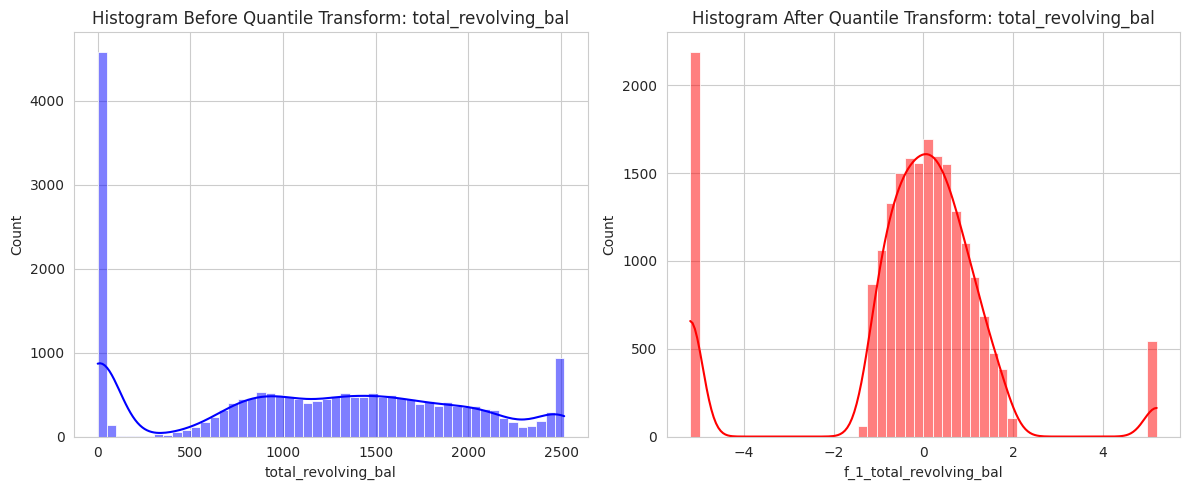

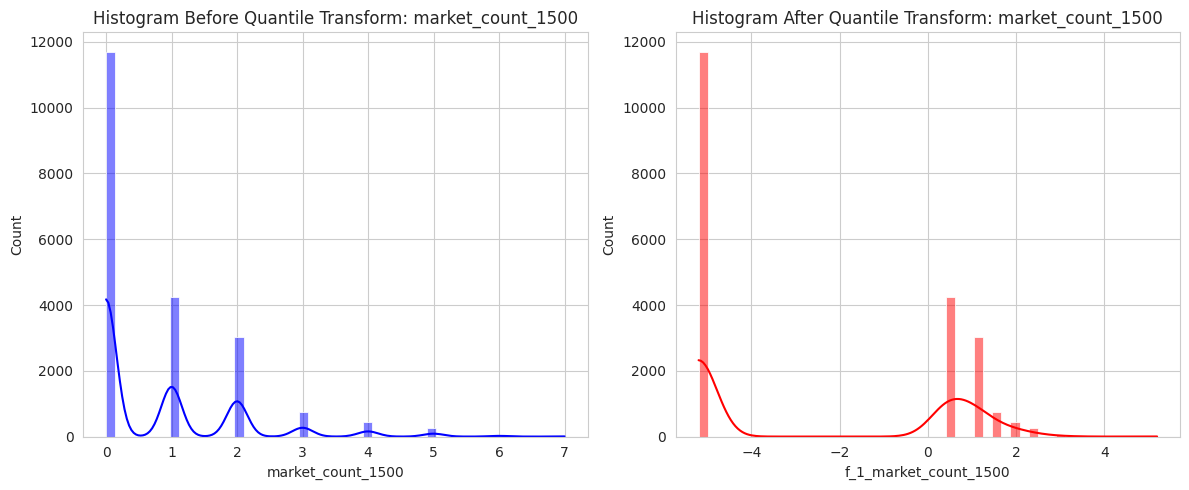

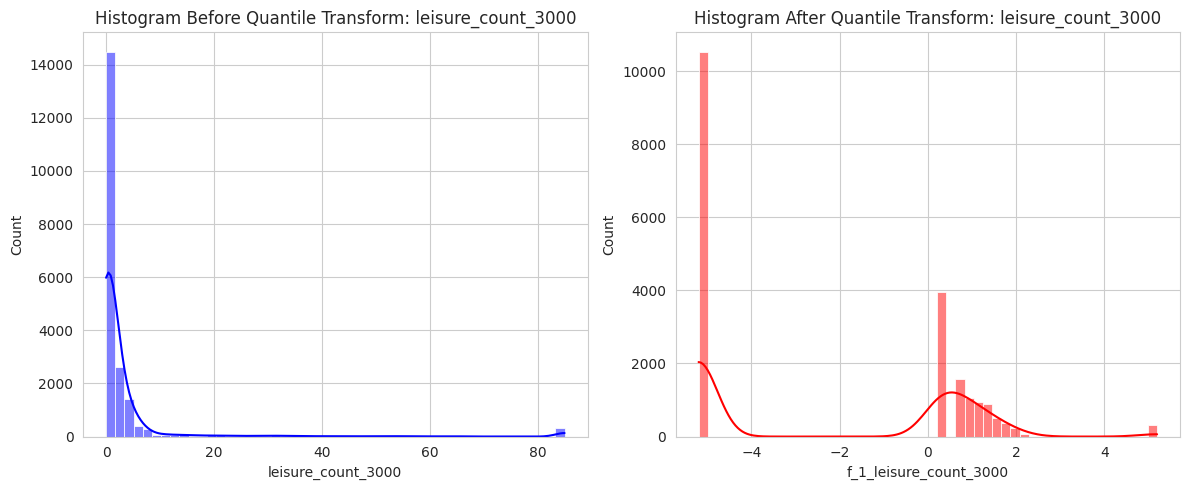

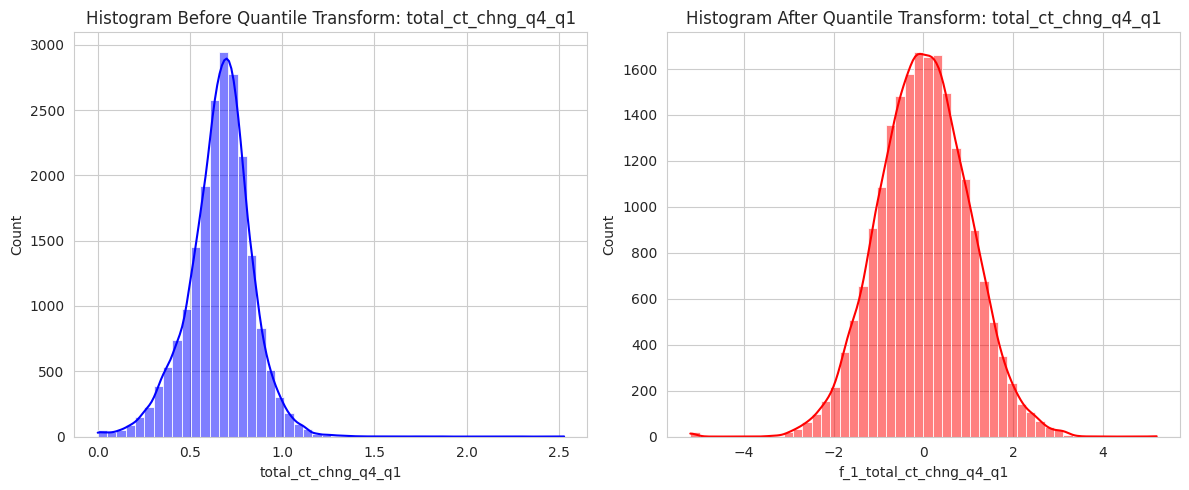

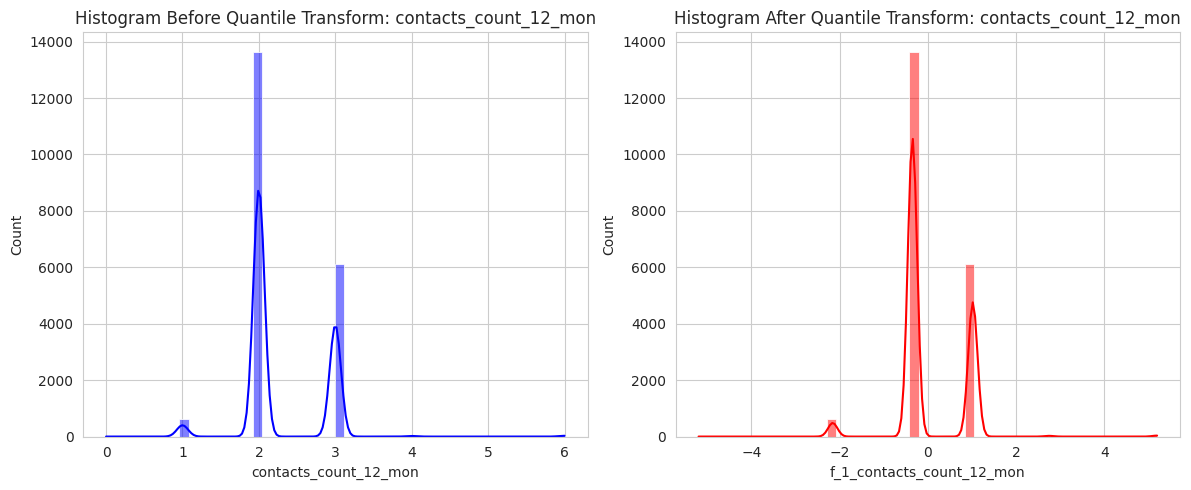

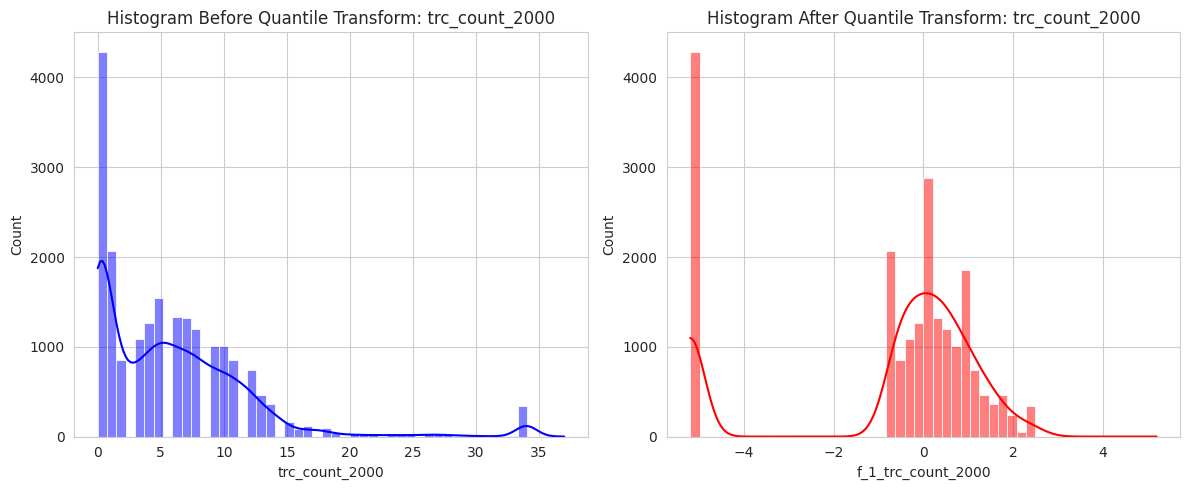

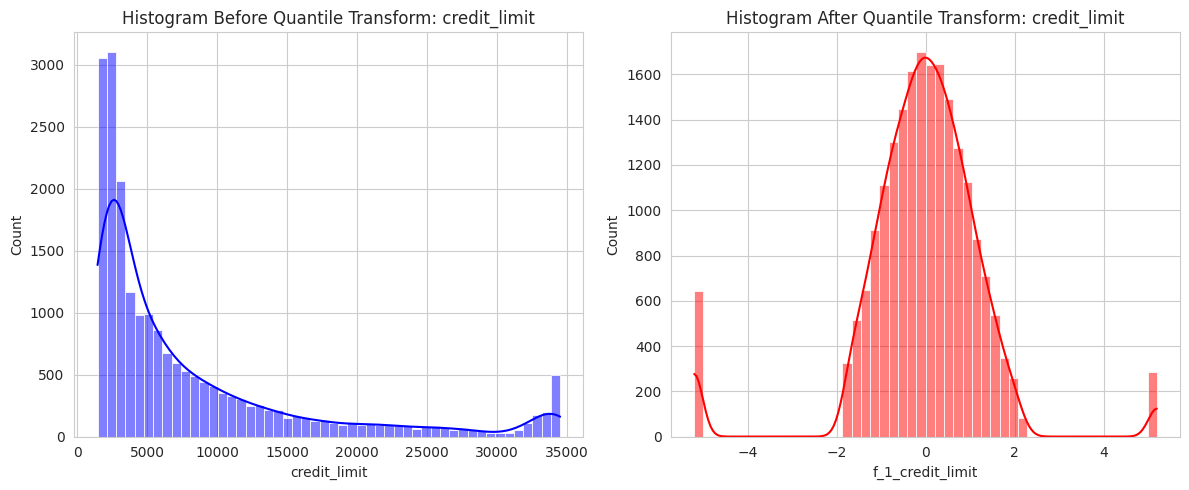

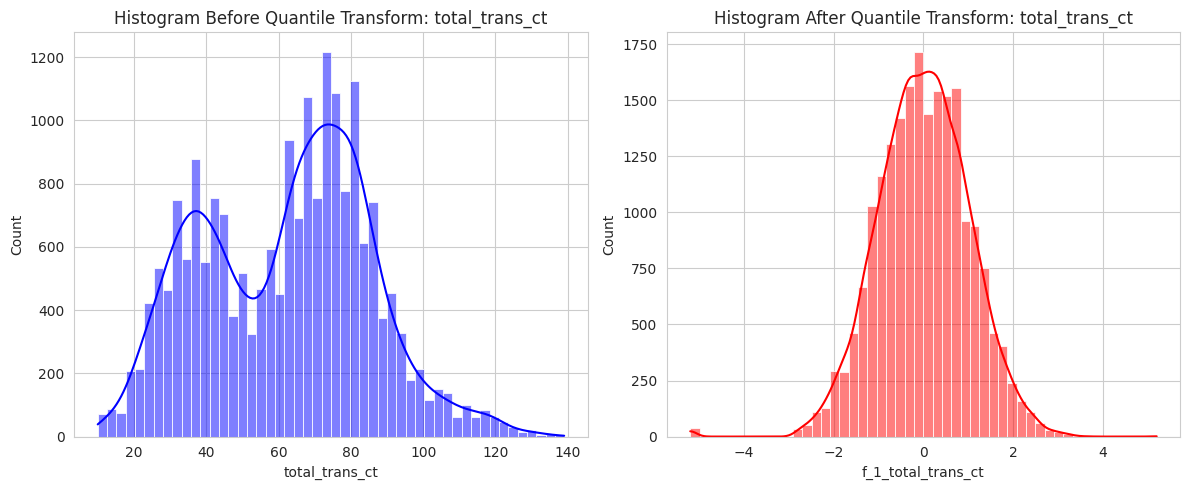

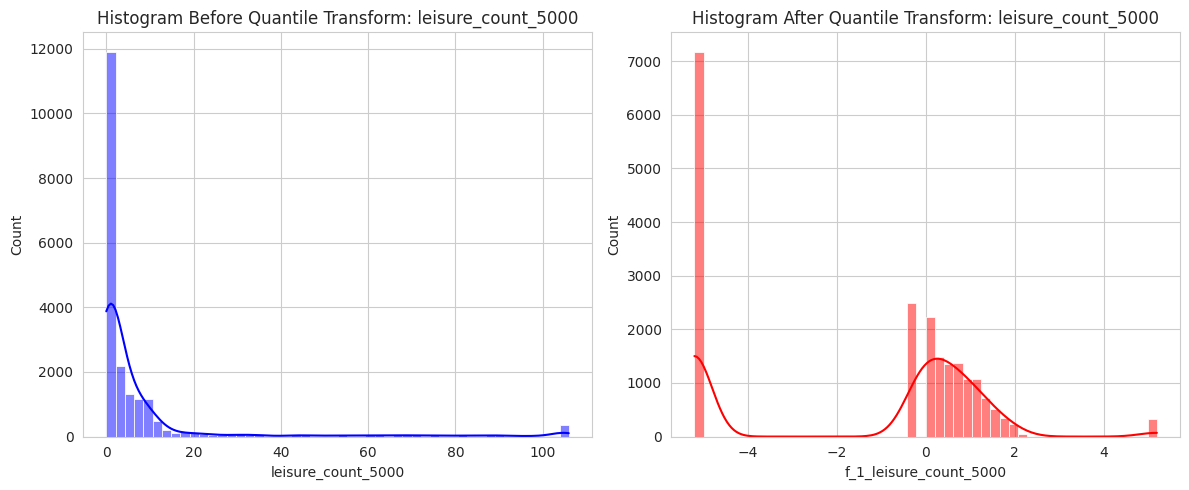

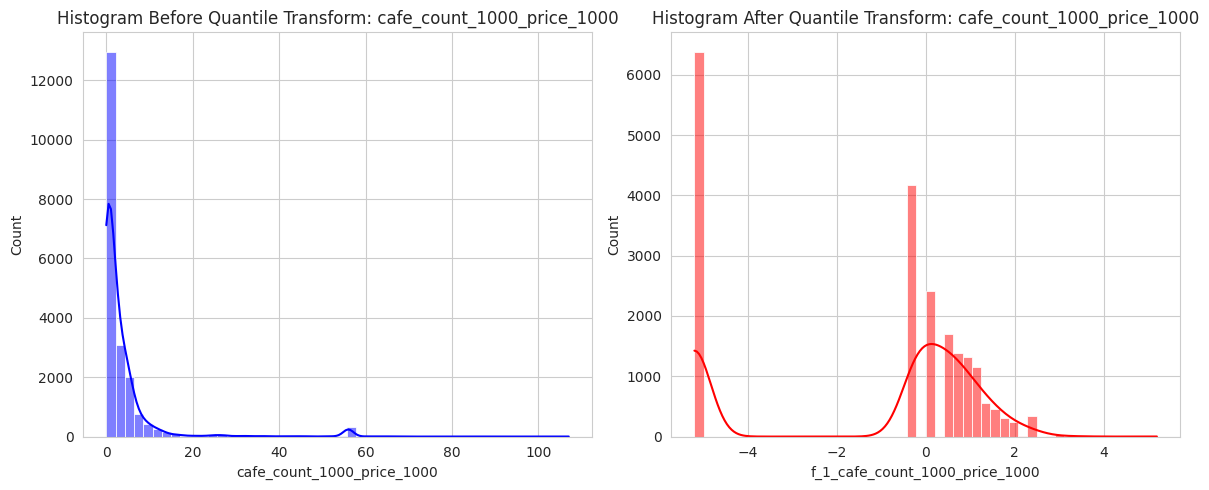

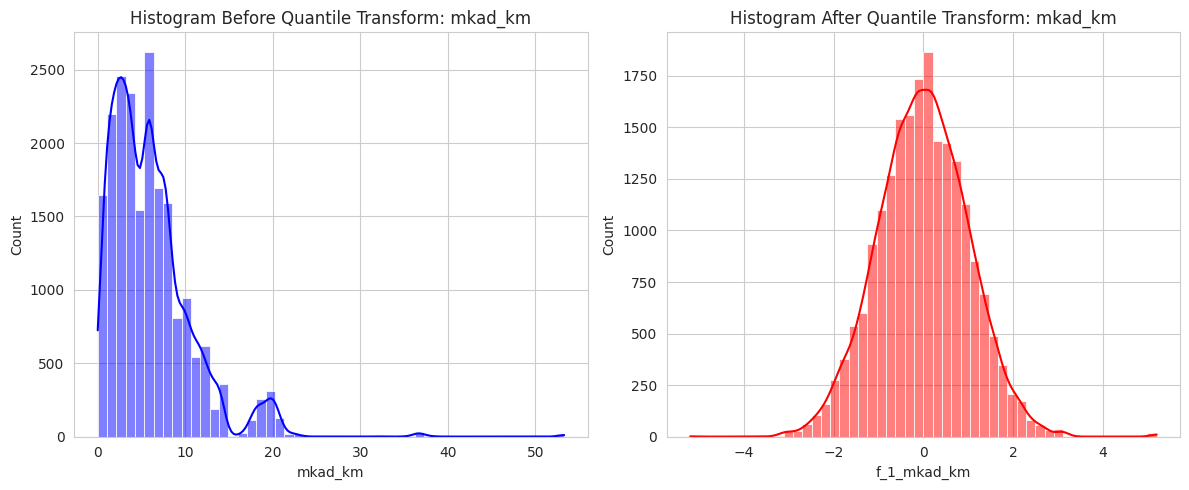

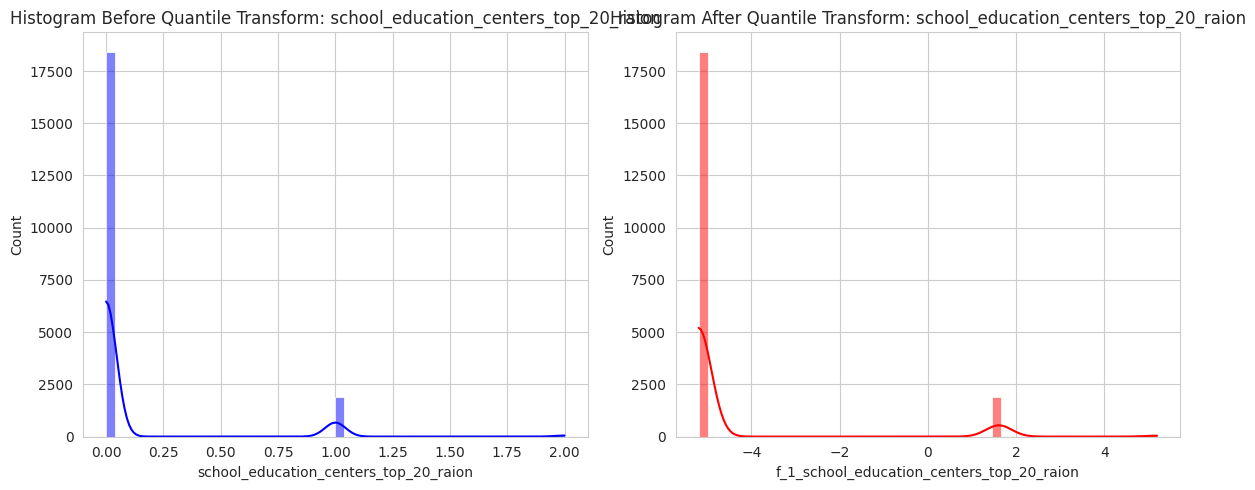

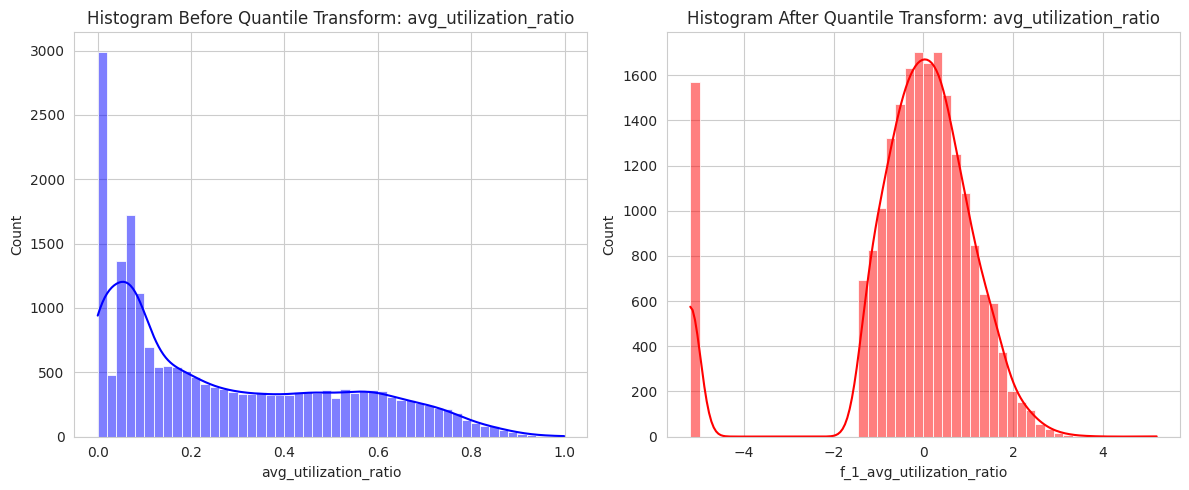

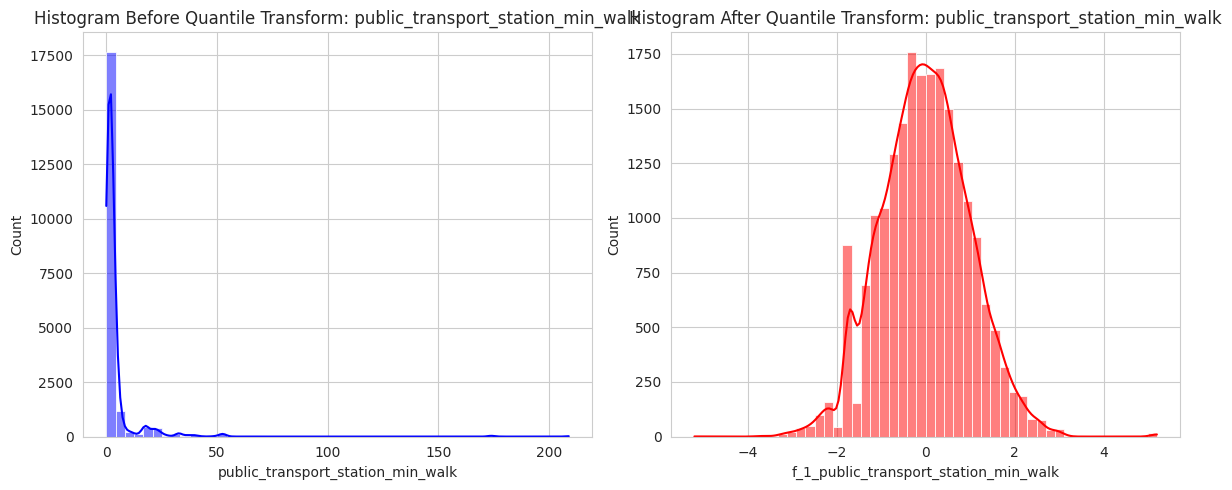

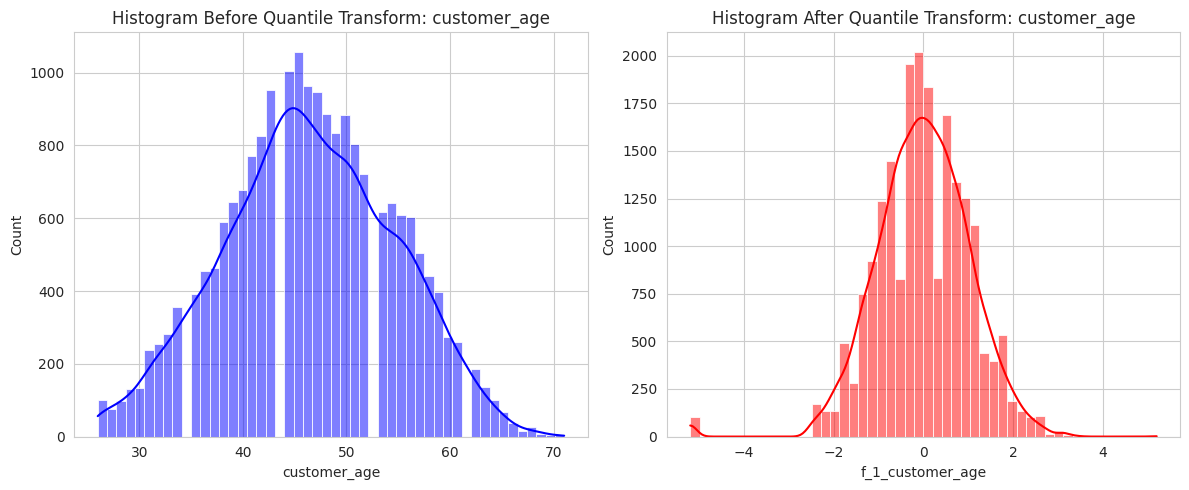

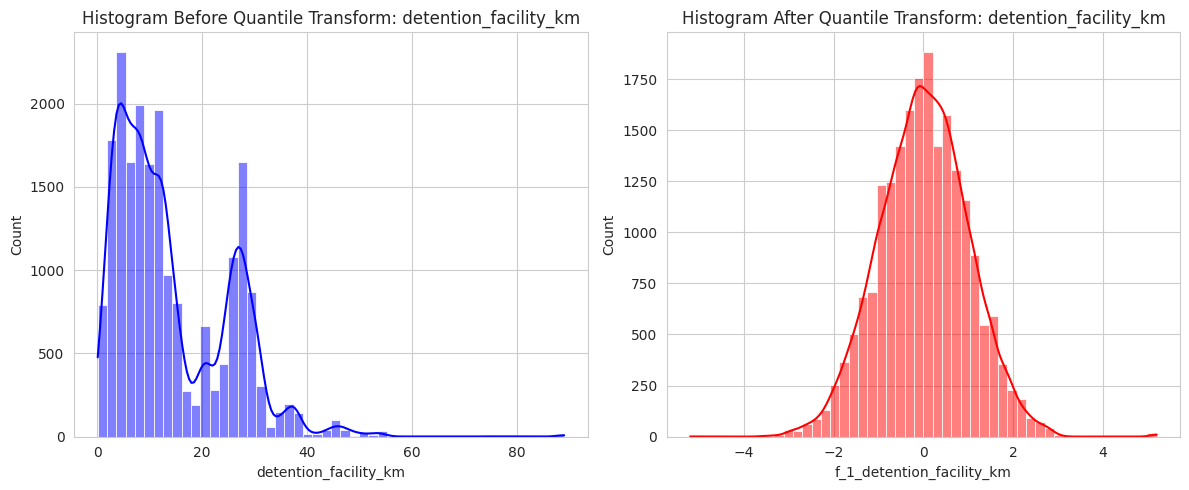

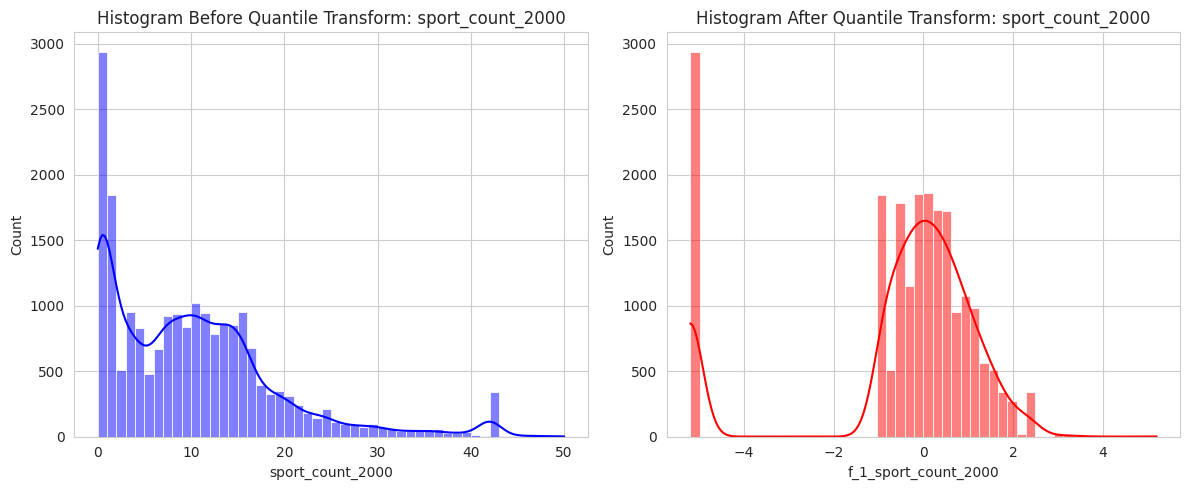

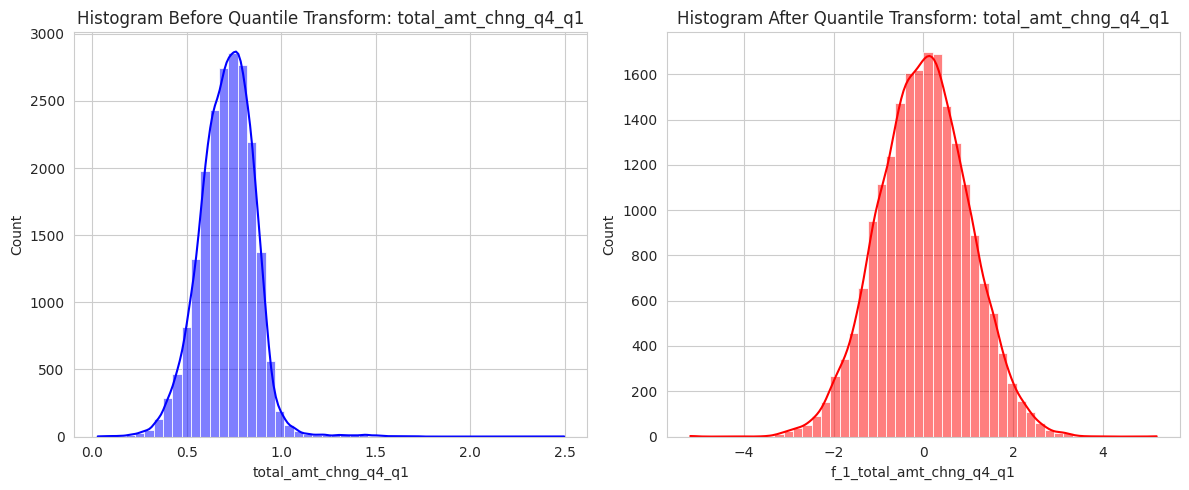

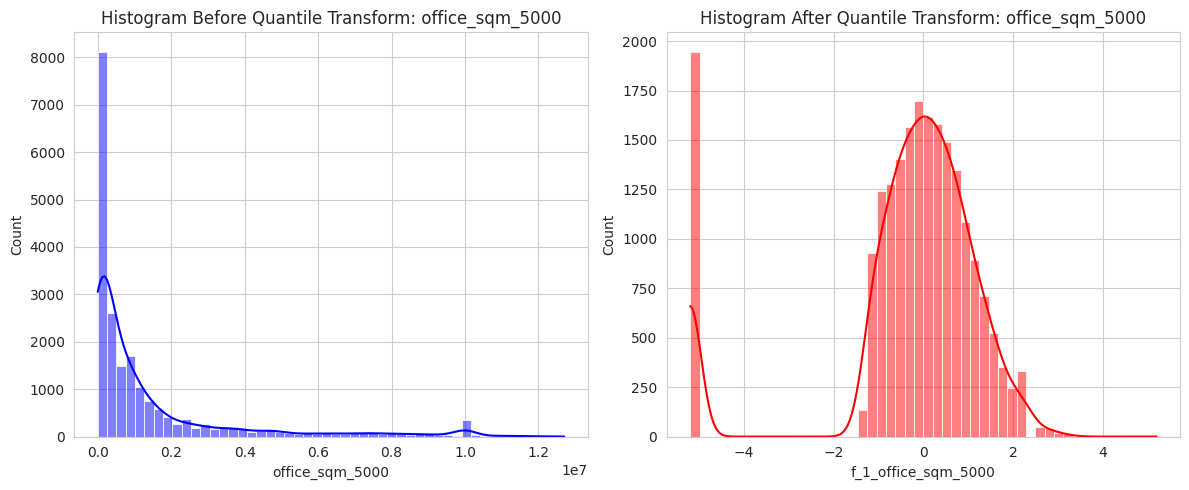

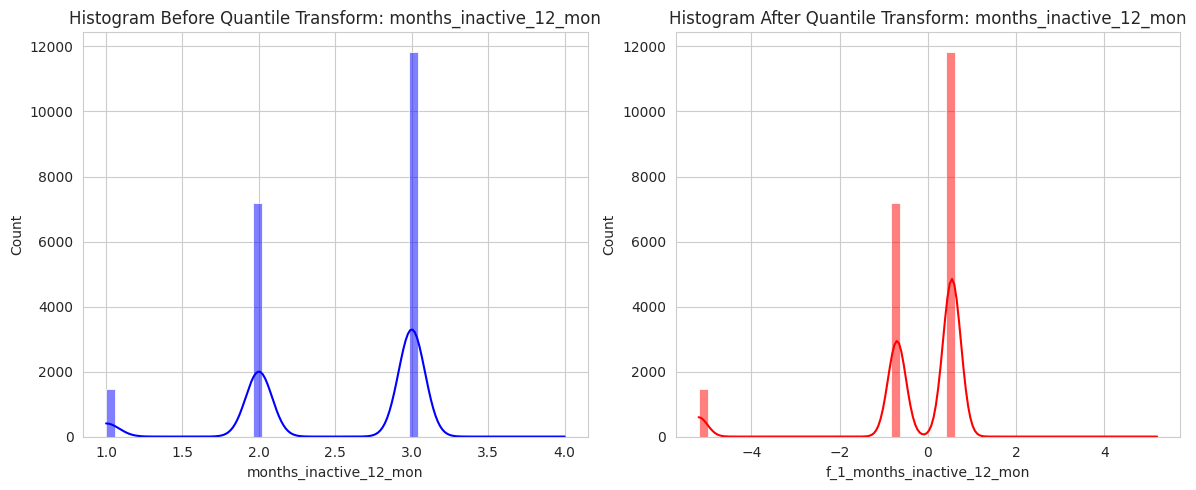

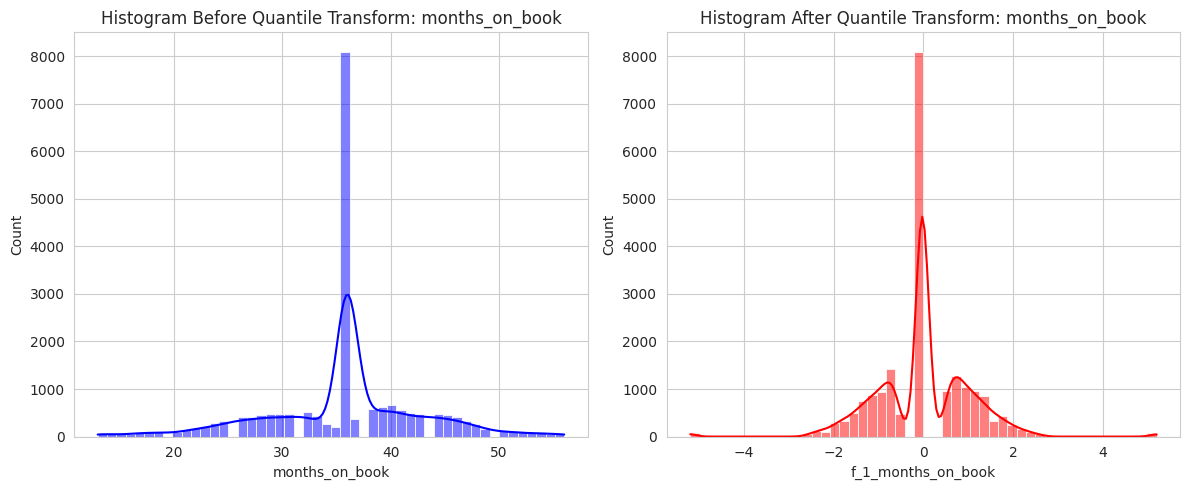

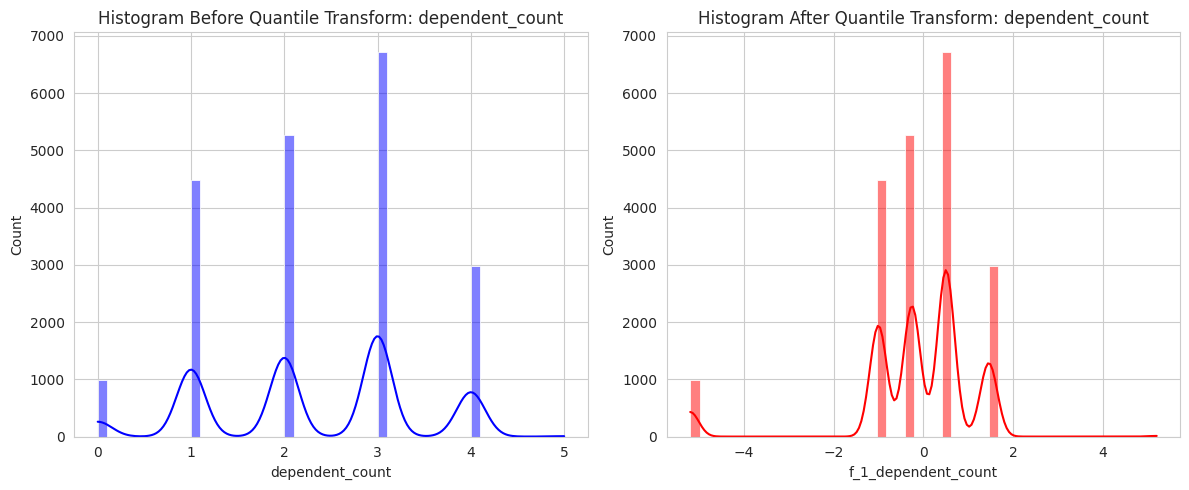

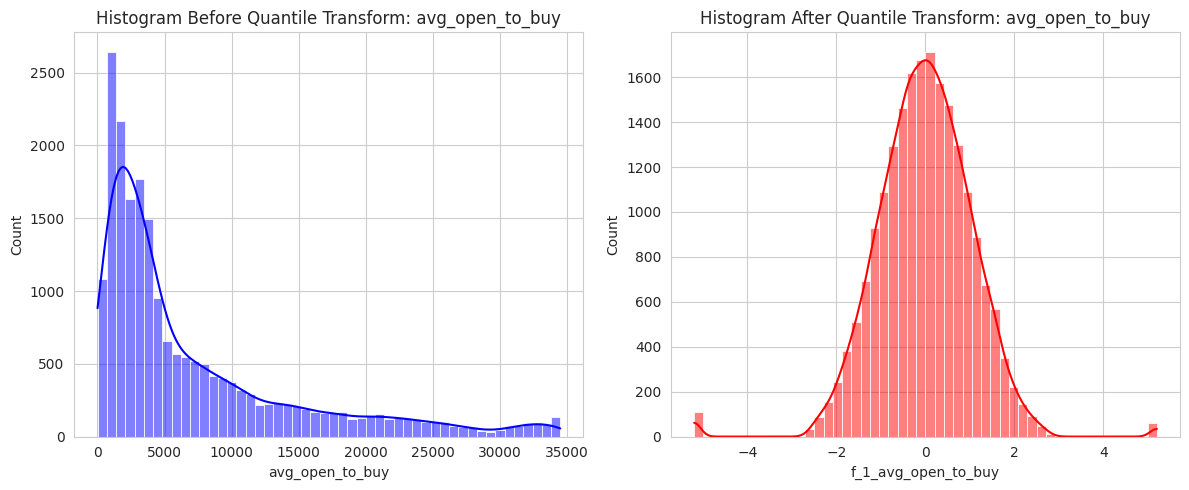

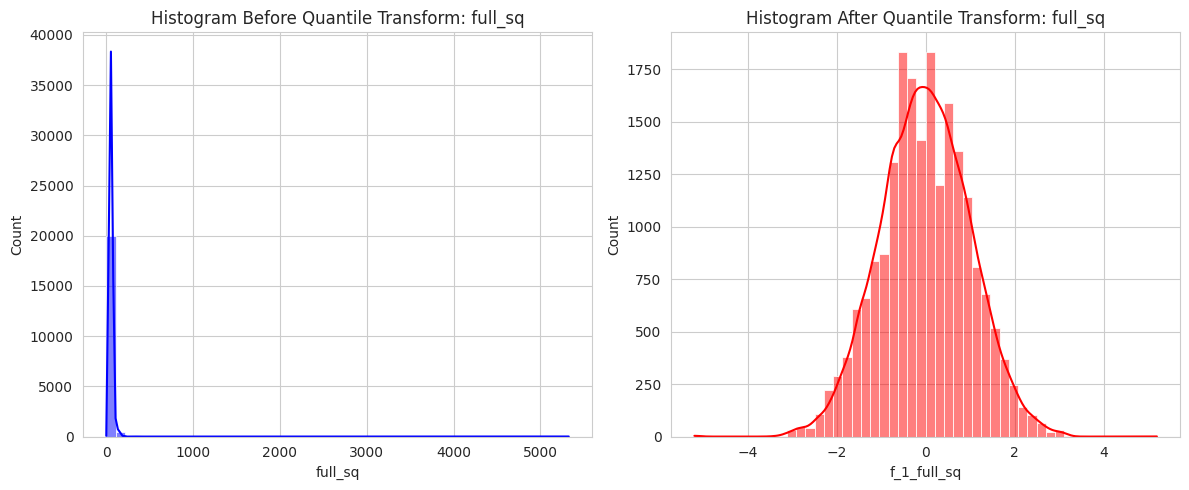

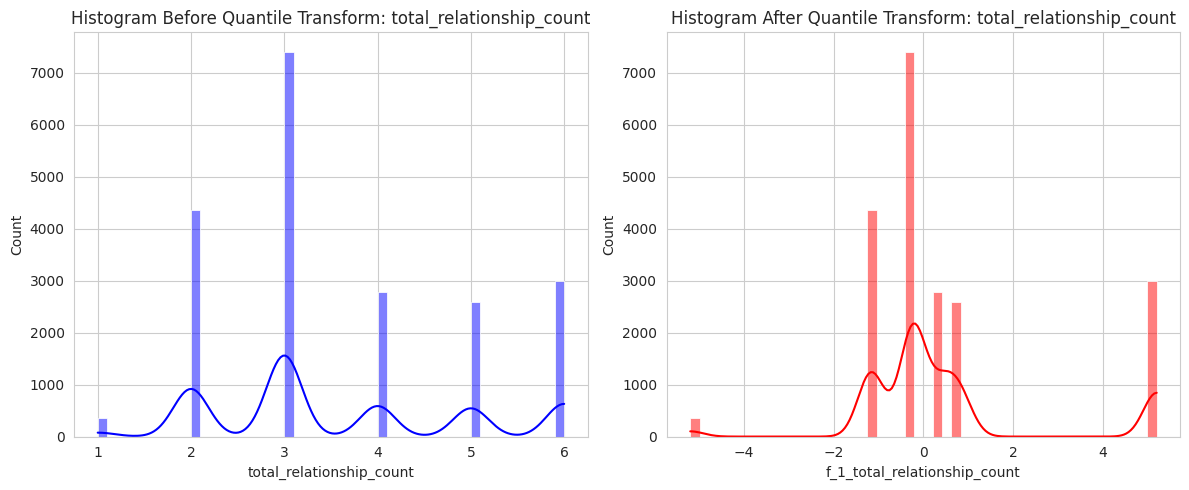

In [49]:
#histogram of normalized features (f_1_)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")


# Loop through each feature and plot before/after transformation
for feature in all_old_features:
    transformed_feature = f'f_1_{feature}'  # Transformed feature name

    # Check if both original and transformed features exist
    if feature in transform_train.columns and transformed_feature in transform_train.columns:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # Histogram Before Transformation
        sns.histplot(transform_train[feature], bins=50, kde=True, ax=ax[0], color='blue')
        ax[0].set_title(f"Histogram Before Quantile Transform: {feature}")
        ax[0].set_xlabel(feature)

        # Histogram After Transformation
        sns.histplot(transform_train[transformed_feature], bins=50, kde=True, ax=ax[1], color='red')
        ax[1].set_title(f"Histogram After Quantile Transform: {feature}")
        ax[1].set_xlabel(transformed_feature)

        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Feature '{feature}' or its transformed version '{transformed_feature}' is missing.")


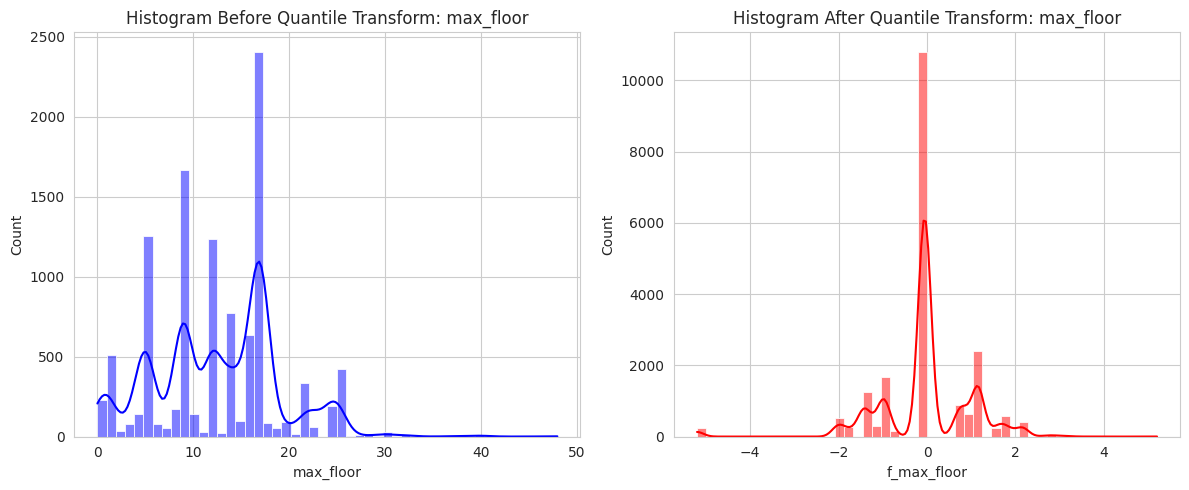

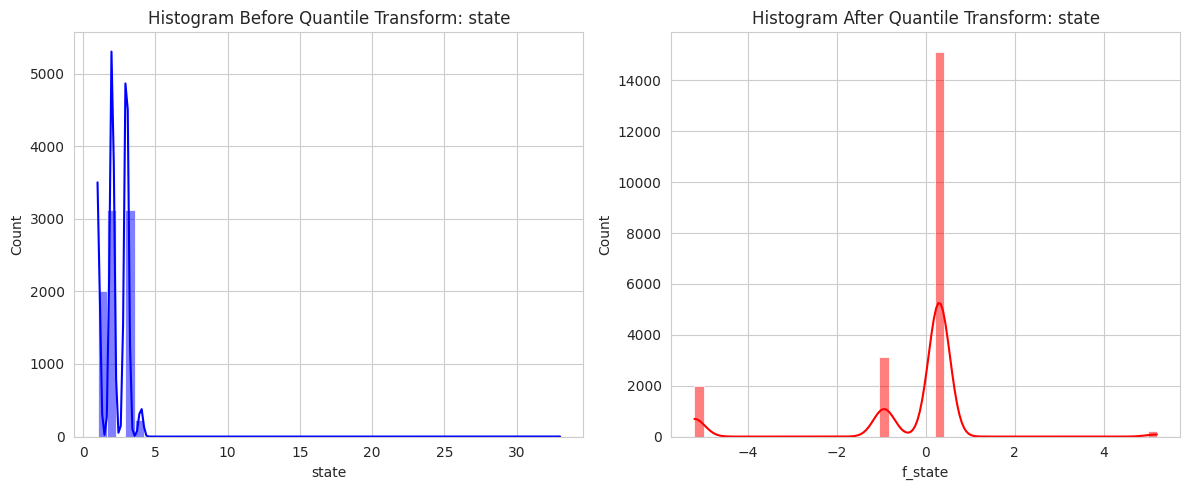

⚠️ Feature 'total_revolving_bal' or its transformed version 'f_total_revolving_bal' is missing.
⚠️ Feature 'market_count_1500' or its transformed version 'f_market_count_1500' is missing.
⚠️ Feature 'leisure_count_3000' or its transformed version 'f_leisure_count_3000' is missing.
⚠️ Feature 'total_ct_chng_q4_q1' or its transformed version 'f_total_ct_chng_q4_q1' is missing.


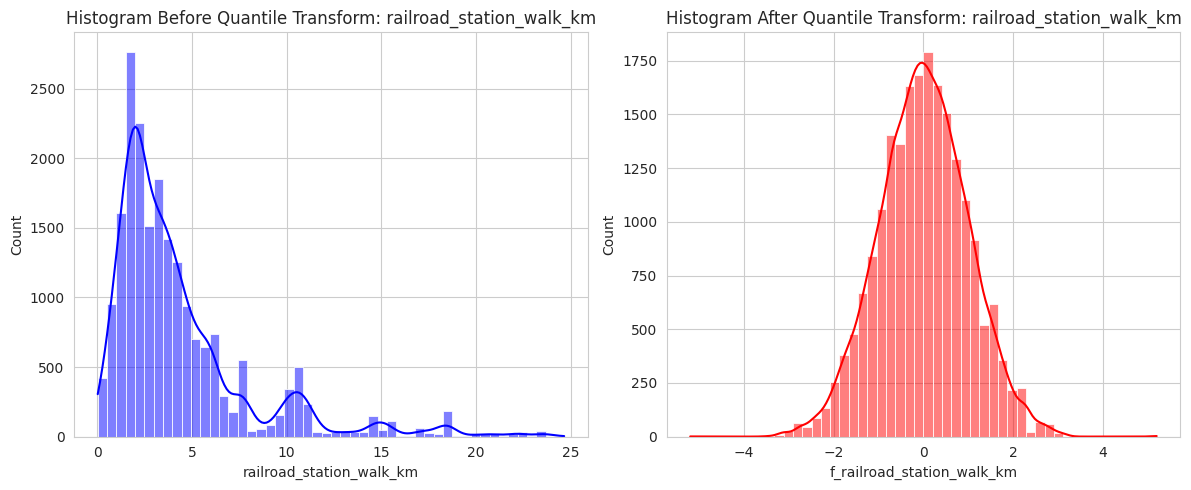

⚠️ Feature 'contacts_count_12_mon' or its transformed version 'f_contacts_count_12_mon' is missing.


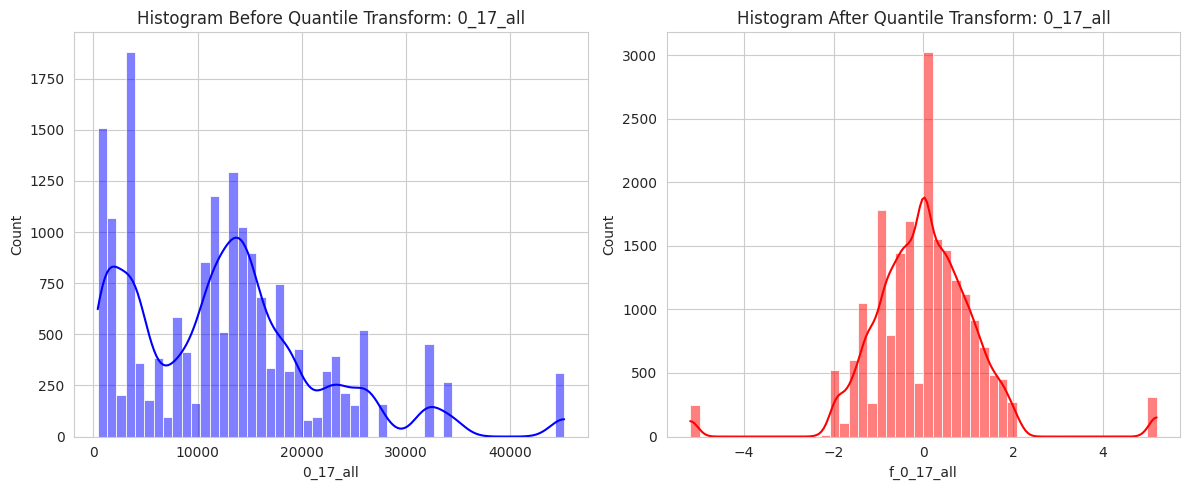

⚠️ Feature 'trc_count_2000' or its transformed version 'f_trc_count_2000' is missing.


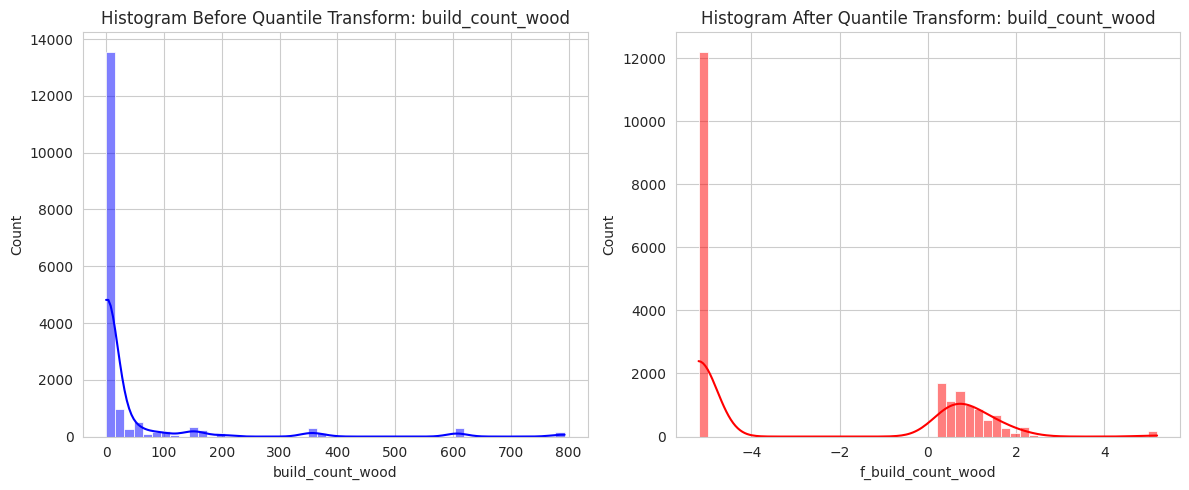

⚠️ Feature 'credit_limit' or its transformed version 'f_credit_limit' is missing.
⚠️ Feature 'total_trans_ct' or its transformed version 'f_total_trans_ct' is missing.
⚠️ Feature 'leisure_count_5000' or its transformed version 'f_leisure_count_5000' is missing.


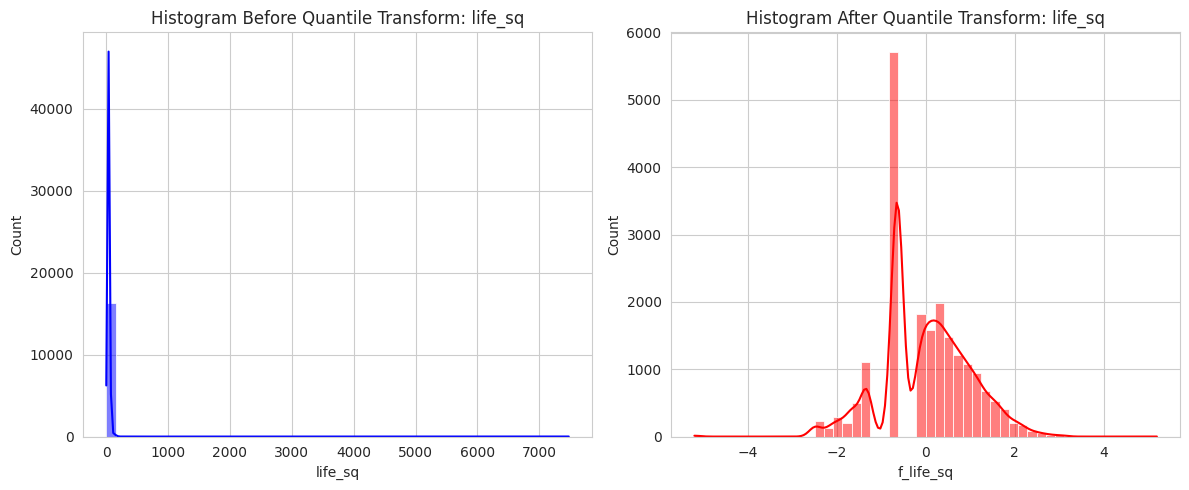

⚠️ Feature 'cafe_count_1000_price_1000' or its transformed version 'f_cafe_count_1000_price_1000' is missing.
⚠️ Feature 'mkad_km' or its transformed version 'f_mkad_km' is missing.
⚠️ Feature 'school_education_centers_top_20_raion' or its transformed version 'f_school_education_centers_top_20_raion' is missing.
⚠️ Feature 'avg_utilization_ratio' or its transformed version 'f_avg_utilization_ratio' is missing.
⚠️ Feature 'public_transport_station_min_walk' or its transformed version 'f_public_transport_station_min_walk' is missing.
⚠️ Feature 'customer_age' or its transformed version 'f_customer_age' is missing.
⚠️ Feature 'detention_facility_km' or its transformed version 'f_detention_facility_km' is missing.
⚠️ Feature 'sport_count_2000' or its transformed version 'f_sport_count_2000' is missing.


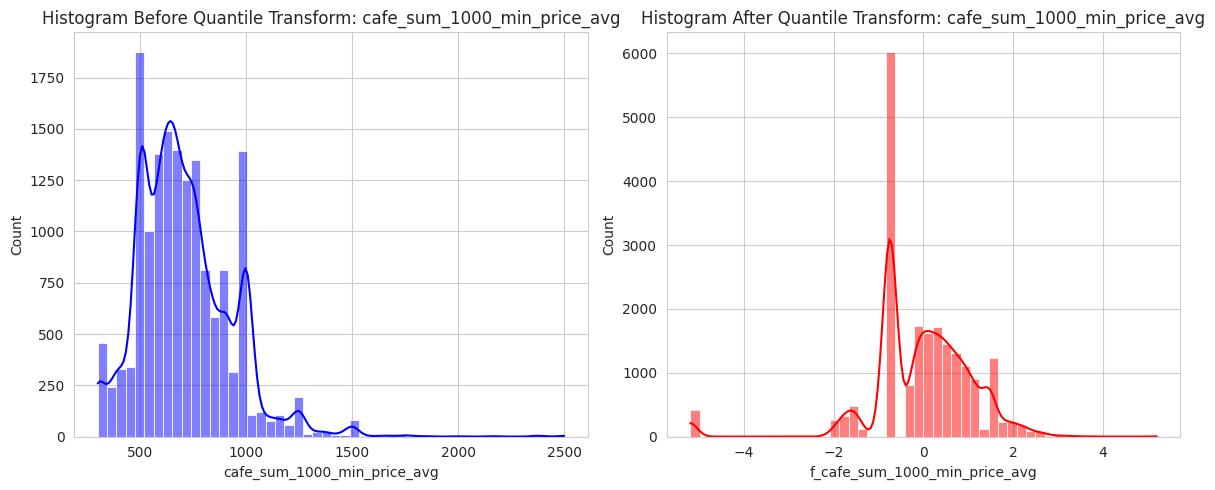

⚠️ Feature 'total_amt_chng_q4_q1' or its transformed version 'f_total_amt_chng_q4_q1' is missing.


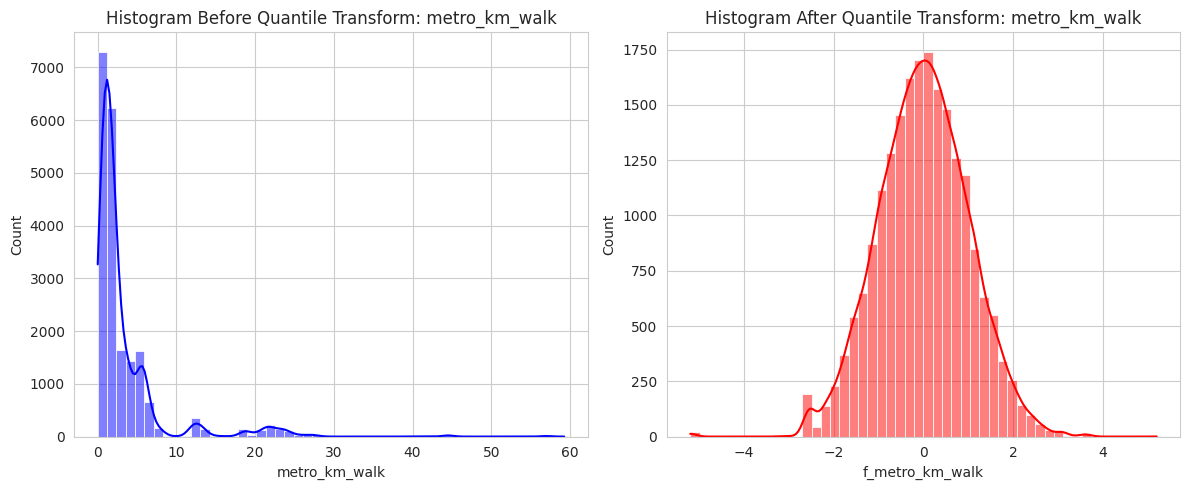

⚠️ Feature 'office_sqm_5000' or its transformed version 'f_office_sqm_5000' is missing.


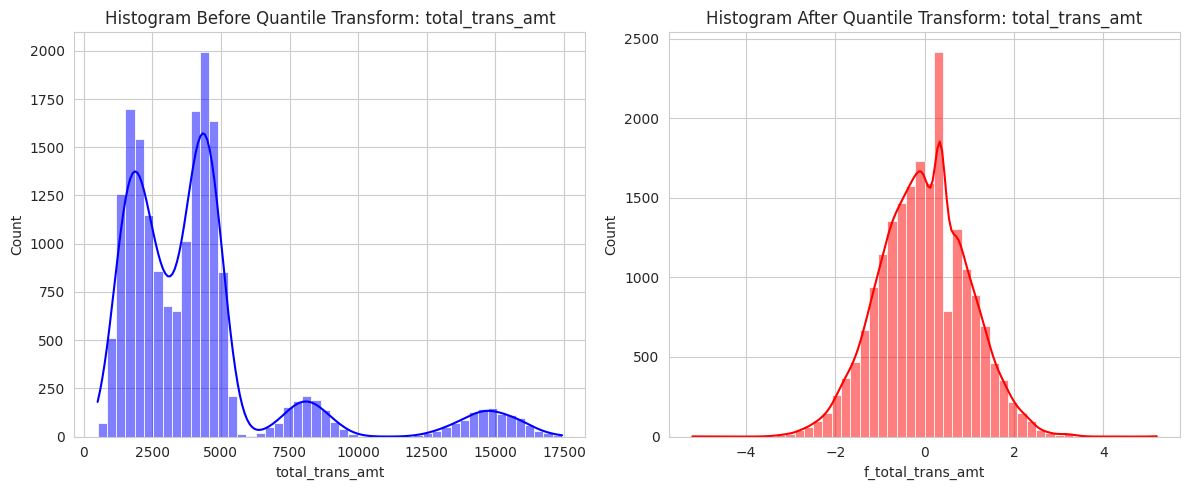

⚠️ Feature 'months_inactive_12_mon' or its transformed version 'f_months_inactive_12_mon' is missing.


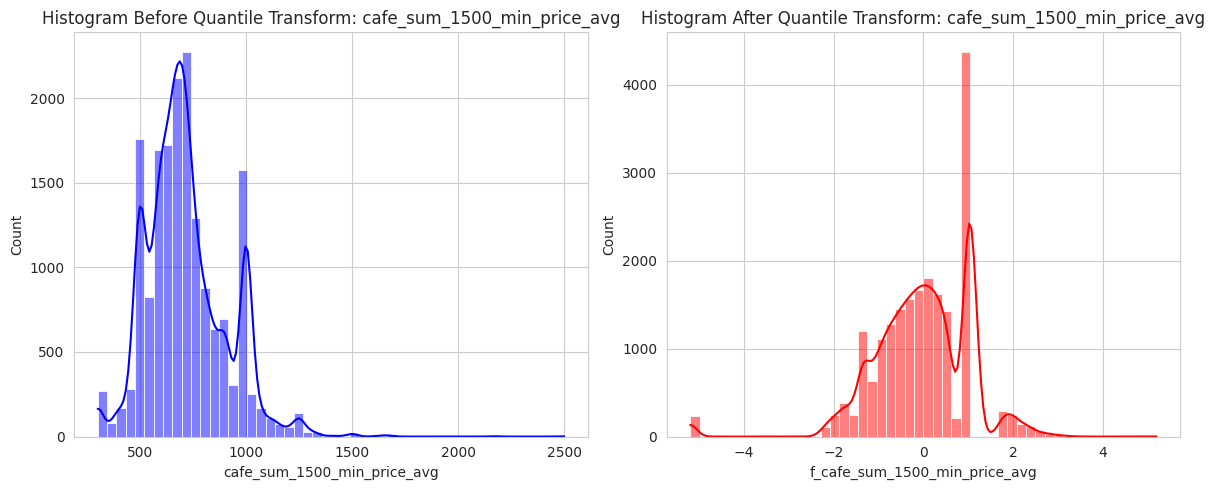

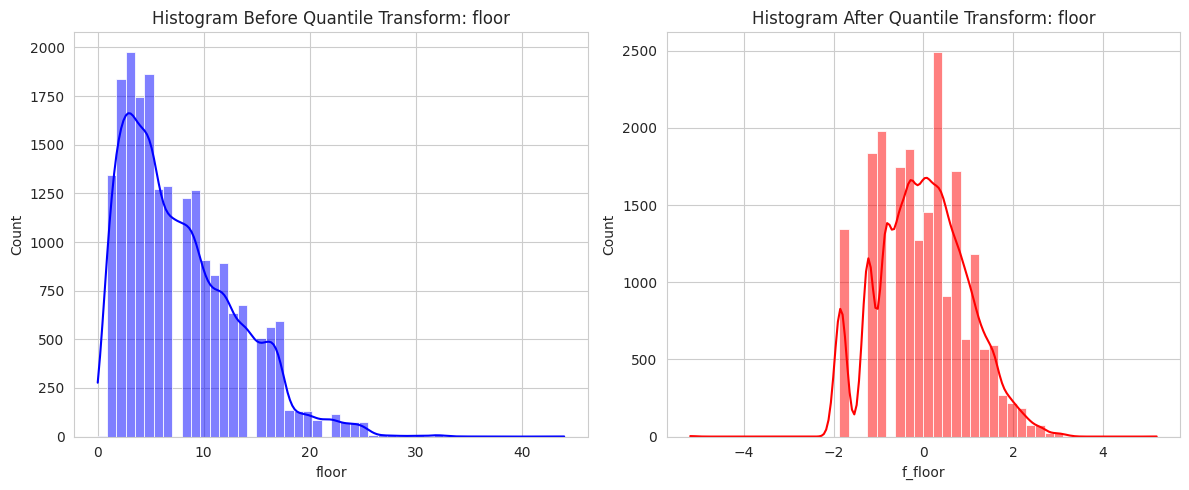

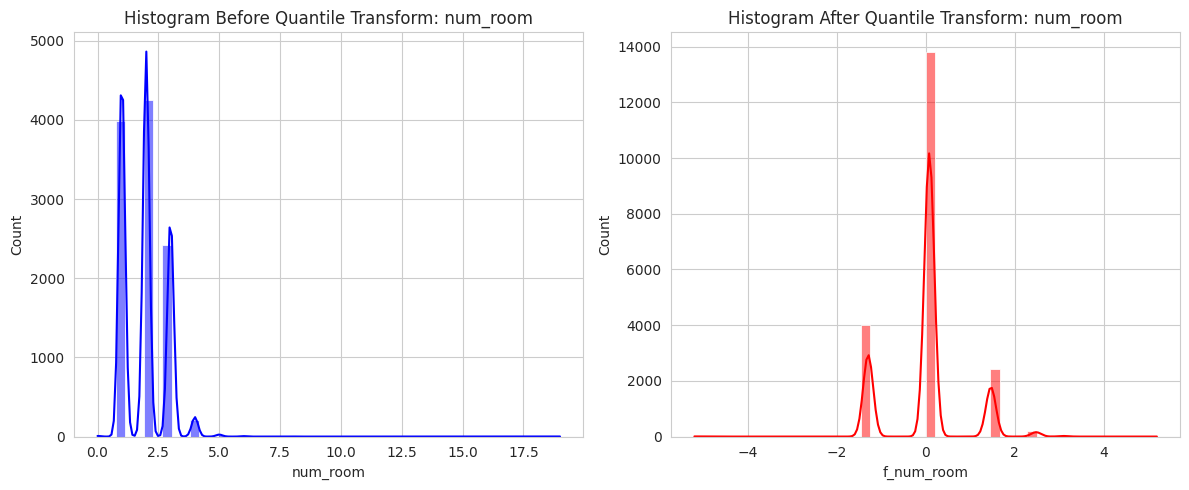

⚠️ Feature 'months_on_book' or its transformed version 'f_months_on_book' is missing.
⚠️ Feature 'dependent_count' or its transformed version 'f_dependent_count' is missing.
⚠️ Feature 'avg_open_to_buy' or its transformed version 'f_avg_open_to_buy' is missing.


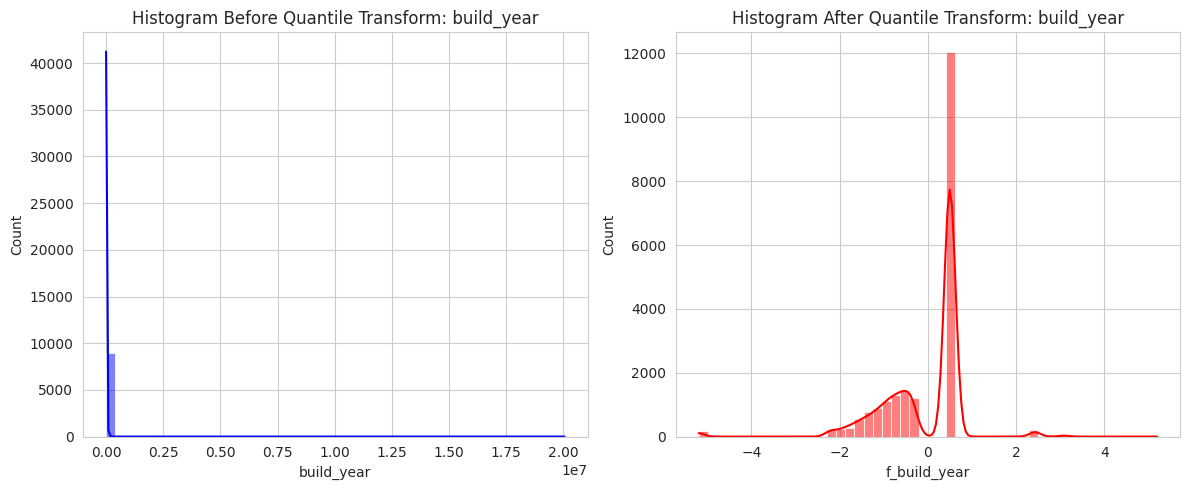

⚠️ Feature 'full_sq' or its transformed version 'f_full_sq' is missing.
⚠️ Feature 'total_relationship_count' or its transformed version 'f_total_relationship_count' is missing.


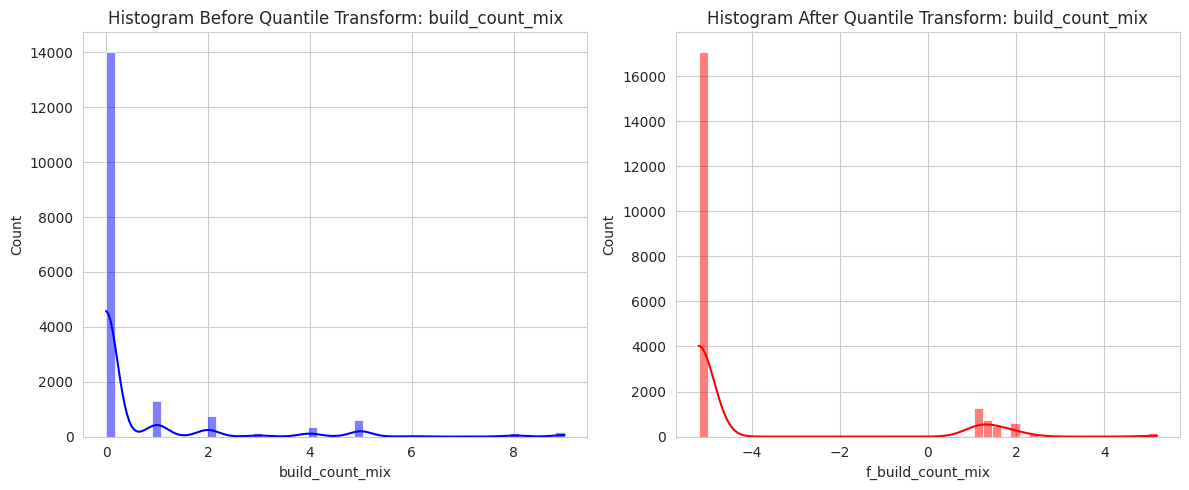

In [51]:
#histogram of normalized features (f_)

# Set style
sns.set_style("whitegrid")

#select feature colums
features_before = [col for col in transform_train.select_dtypes(include=['int64', 'float64'])
if not col.startswith('f_') and col not in ['__churn',
 '__price_doc'] ]

# Loop through each feature and plot before/after transformation
for feature in features_before:
    transformed_feature = f'f_{feature}'  # Transformed feature name

    # Check if both original and transformed features exist
    if feature in transform_train.columns and transformed_feature in transform_train.columns:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # Histogram Before Transformation
        sns.histplot(transform_train[feature], bins=50, kde=True, ax=ax[0], color='blue')
        ax[0].set_title(f"Histogram Before Quantile Transform: {feature}")
        ax[0].set_xlabel(feature)

        # Histogram After Transformation
        sns.histplot(transform_train[transformed_feature], bins=50, kde=True, ax=ax[1], color='red')
        ax[1].set_title(f"Histogram After Quantile Transform: {feature}")
        ax[1].set_xlabel(transformed_feature)

        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Feature '{feature}' or its transformed version '{transformed_feature}' is missing.")


In [52]:
transform_train.shape, transform_test.shape

((20483, 127), (9183, 126))

In [ ]:
#check to see if the columns below were not altered after the transformation
columns___ =['state', 'railroad_station_walk_km', 'build_count_wood',
      'life_sq', 'cafe_sum_1000_min_price_avg', 'metro_km_walk',
      'cafe_sum_1500_min_price_avg', 'build_year', 'build_count_mix']
select = train[columns___]

select.head(20).T

0           1           2           3   \
state                               NaN         NaN         NaN         NaN   
railroad_station_walk_km       5.419893    3.411993    1.277658    4.291432   
build_count_wood               0.000000    1.000000    0.000000   51.000000   
life_sq                       27.000000   19.000000   29.000000   50.000000   
cafe_sum_1000_min_price_avg  527.780000  615.380000  642.860000  658.330000   
metro_km_walk                  1.131260    0.635053    1.445960    0.963802   
cafe_sum_1500_min_price_avg  566.670000  694.120000  516.670000  673.910000   
build_year                          NaN         NaN         NaN         NaN   
build_count_mix                0.000000    0.000000    0.000000    2.000000   

                                     4           5           6           7   \
state                               NaN         NaN         NaN         NaN   
railroad_station_walk_km       0.853960    0.375312    2.603671    4.309575   
build_count_wood               0.000000    0.000000    1.000000    0.000000   
life_sq                       77.000000   46.000000   14.000000   44.000000   
cafe_sum_1000_min_price_avg  763.450000  883.330000  760.000000  784.620000   
metro_km_walk                  0.688859    1.531514    1.026916    0.960649   
cafe_sum_1500_min_price_avg  766.800000  718.180000  673.170000  585.710000   
build_year                          NaN         NaN         NaN         NaN   
build_count_mix                1.000000    0.000000    1.000000    0.000000   

                                     8           9           10          11  \
state                               NaN         NaN         NaN         NaN   
railroad_station_walk_km       1.540958    2.522422    3.432120    4.978186   
build_count_wood               2.000000  204.000000  793.000000   11.000000   
life_sq                       27.000000   21.000000   19.000000   19.000000   
cafe_sum_1000_min_price_avg  566.670000  620.000000  750.000000         NaN   
metro_km_walk                  1.228524    0.396275    1.238349    2.306504   
cafe_sum_1500_min_price_avg  592.310000  788.890000  750.000000  766.670000   
build_year                          NaN         NaN         NaN         NaN   
build_count_mix                0.000000    1.000000    9.000000    0.000000   

                                     12           13          14          15  \
state                               NaN          NaN         NaN         NaN   
railroad_station_walk_km       0.635649     1.254206    0.904529    3.681023   
build_count_wood             204.000000     6.000000    0.000000    0.000000   
life_sq                       28.000000    31.000000   21.000000   31.000000   
cafe_sum_1000_min_price_avg  575.000000   989.580000  554.840000  590.910000   
metro_km_walk                  1.623329     1.214706    0.590130    1.045237   
cafe_sum_1500_min_price_avg  630.770000  1019.300000  544.120000  613.790000   
build_year                          NaN          NaN         NaN         NaN   
build_count_mix                1.000000     1.000000    0.000000    0.000000   

                                     16          17          18          19  
state                               NaN         NaN         NaN         NaN  
railroad_station_walk_km       2.393325    2.400835    3.788198    3.774845  
build_count_wood               0.000000    0.000000  793.000000    0.000000  
life_sq                       31.000000   28.000000   33.000000   29.000000  
cafe_sum_1000_min_price_avg  600.000000  577.780000  750.000000  660.000000  
metro_km_walk                  0.621104    1.177877    1.428758    1.326009  
cafe_sum_1500_min_price_avg  581.250000  735.710000  750.000000  705.260000  
build_year                          NaN         NaN         NaN         NaN  
build_count_mix                0.000000    0.000000    9.000000    0.000000

In [ ]:
#Apparently they are still the same
select1 = transform_train[columns___]

select1.head(20).T

0           1           2           3   \
state                               NaN         NaN         NaN         NaN   
railroad_station_walk_km       5.419893    3.411993    1.277658    4.291432   
build_count_wood               0.000000    1.000000    0.000000   51.000000   
life_sq                       27.000000   19.000000   29.000000   50.000000   
cafe_sum_1000_min_price_avg  527.780000  615.380000  642.860000  658.330000   
metro_km_walk                  1.131260    0.635053    1.445960    0.963802   
cafe_sum_1500_min_price_avg  566.670000  694.120000  516.670000  673.910000   
build_year                          NaN         NaN         NaN         NaN   
build_count_mix                0.000000    0.000000    0.000000    2.000000   

                                     4           5           6           7   \
state                               NaN         NaN         NaN         NaN   
railroad_station_walk_km       0.853960    0.375312    2.603671    4.309575   
build_count_wood               0.000000    0.000000    1.000000    0.000000   
life_sq                       77.000000   46.000000   14.000000   44.000000   
cafe_sum_1000_min_price_avg  763.450000  883.330000  760.000000  784.620000   
metro_km_walk                  0.688859    1.531514    1.026916    0.960649   
cafe_sum_1500_min_price_avg  766.800000  718.180000  673.170000  585.710000   
build_year                          NaN         NaN         NaN         NaN   
build_count_mix                1.000000    0.000000    1.000000    0.000000   

                                     8           9           10          11  \
state                               NaN         NaN         NaN         NaN   
railroad_station_walk_km       1.540958    2.522422    3.432120    4.978186   
build_count_wood               2.000000  204.000000  793.000000   11.000000   
life_sq                       27.000000   21.000000   19.000000   19.000000   
cafe_sum_1000_min_price_avg  566.670000  620.000000  750.000000         NaN   
metro_km_walk                  1.228524    0.396275    1.238349    2.306504   
cafe_sum_1500_min_price_avg  592.310000  788.890000  750.000000  766.670000   
build_year                          NaN         NaN         NaN         NaN   
build_count_mix                0.000000    1.000000    9.000000    0.000000   

                                     12           13          14          15  \
state                               NaN          NaN         NaN         NaN   
railroad_station_walk_km       0.635649     1.254206    0.904529    3.681023   
build_count_wood             204.000000     6.000000    0.000000    0.000000   
life_sq                       28.000000    31.000000   21.000000   31.000000   
cafe_sum_1000_min_price_avg  575.000000   989.580000  554.840000  590.910000   
metro_km_walk                  1.623329     1.214706    0.590130    1.045237   
cafe_sum_1500_min_price_avg  630.770000  1019.300000  544.120000  613.790000   
build_year                          NaN          NaN         NaN         NaN   
build_count_mix                1.000000     1.000000    0.000000    0.000000   

                                     16          17          18          19  
state                               NaN         NaN         NaN         NaN  
railroad_station_walk_km       2.393325    2.400835    3.788198    3.774845  
build_count_wood               0.000000    0.000000  793.000000    0.000000  
life_sq                       31.000000   28.000000   33.000000   29.000000  
cafe_sum_1000_min_price_avg  600.000000  577.780000  750.000000  660.000000  
metro_km_walk                  0.621104    1.177877    1.428758    1.326009  
cafe_sum_1500_min_price_avg  581.250000  735.710000  750.000000  705.260000  
build_year                          NaN         NaN         NaN         NaN  
build_count_mix                0.000000    0.000000    9.000000    0.000000

Submission

In [53]:
import os

# Ensure the save directory exists
save_dir = "/content/"
os.makedirs(save_dir, exist_ok=True)  # Creates the directory if it doesn't exist


if transform_train.shape[0] != TRAIN_SHAPE[0]:
    raise ValueError(f'Incorrect train file shape. Original {TRAIN_SHAPE[0]}. {transform_train.shape[0]} are given')
# index must be True
transform_train.to_csv(f'{save_dir}/1_{NAME}_train.csv', index=True)

if transform_test.shape[0] != TEST_SHAPE[0]:
    raise ValueError(f'Incorrect test file shape. Original {TEST_SHAPE[0]}. {transform_test.shape[0]} are given')
# index must be True
transform_test.to_csv(f'{save_dir}/1_{NAME}_test.csv', index=True)

print("Files saved successfully!")

Files saved successfully!
